# Challenge 2: Kernel Ridge Regression and Kernel PCA

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge_two.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

The challenge is to show why it is better (or not) to use kernelised methods in two toy data sets, and find out which kernel is the most suitable for each.    
There are two main tasks:
1. Ridge Regression vs Kernel Ridge Regression
2. PCA vs Kernel PCA

Tip: *for the whole challenge, you can use ```sklearn```.*

Code snap that imports all necessary libraries.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import ridge_regression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from seaborn import pairplot
from scipy.linalg import norm
from copy import deepcopy
from scipy.linalg import eigh
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 1. Ridge Regression
Using the training and test data sets created in the following cell, what you have to do is:
* Fit a linear Ridge Regression model;
* Fit a Kernel Ridge Regression model with a Gaussian kernel and one with a Polynomial kernel. Through a grid search, see how different values for gamma for the Gaussian, and different degrees and values for the regularisation term for the Polynomial, change the line that gets fitted by the model.   
Lastly, fit one last KRR with the best kernel and best parameters that you found (the ones that minimise the test error).

For each subtask, calculate the RMSE on the test data set and plot a visual representation of each fitted line, also when trying different values for the parameters.

We generate the dataset starting from a Gaussian distribution. The dataset will be composed of 2000 train points and 1000 test points and the train set will have some eps-noise added to it.

In [529]:
# create training dataset
train_points = 2000
eps = np.random.normal(0, 1, train_points)

X_train = np.linspace(-5, 5, train_points)
y_train = (X_train+4) * (X_train+1) * (np.cos(X_train)-1) * (X_train-3) + eps

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

# create testing data set
test_points = 1000

X_test = np.linspace(-5, 5, test_points)
y_test = (X_test+4) * (X_test+1) * (np.cos(X_test)-1) * (X_test-3)

X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

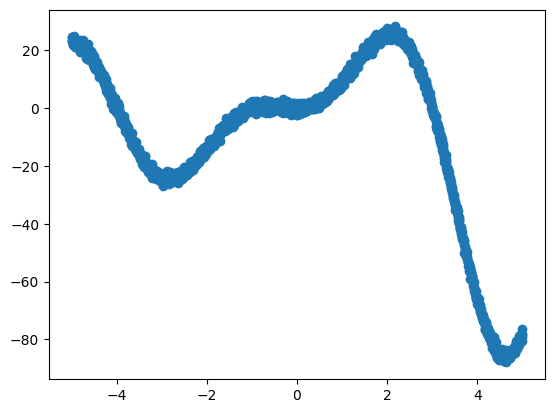

In [55]:
# Plot the train set
plt.plot(X_train, y_train, 'o')

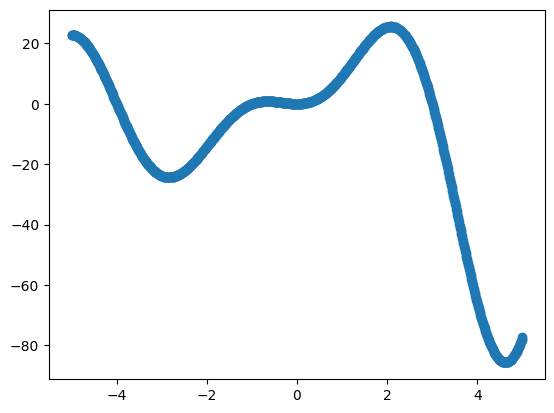

In [56]:
# Plot the test set
plt.plot(X_test, y_test, 'o')

### Fit a linear ridge regression model

#### First using sklearn

In [57]:
coef, intercept = ridge_regression(X_train, y_train, alpha=1.0, return_intercept=True)

print(coef)
print(intercept)

[[-4.38678235]]
-10.065083319481158


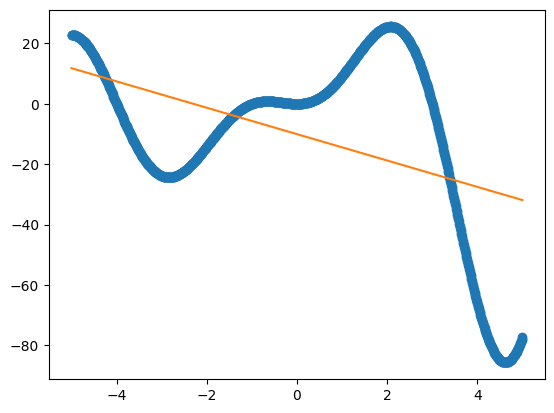

In [51]:
plt.plot(X_test, y_test, 'o')
plt.plot(X_test, coef[0]*X_test + intercept)

In [60]:
print(f"The RMSE on the test set using a ridge regression from sklearn is: {mean_squared_error(y_test, coef[0]*X_test + intercept, squared = False)}")

The RMSE on the test set using a ridge regression from sklearn is: 26.754437037853315


C:\Users\Davide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Then just with our math


In [61]:
x_temp = np.stack([X_train[:,0], np.ones(X_train.shape[0])], axis=1).reshape(-1,2)

lam = 1
k = np.linalg.inv(np.dot(x_temp.T,x_temp) + lam * np.eye(x_temp.shape[1]))
w_ridge = np.dot(k,np.dot(x_temp.T,y_train))

In [62]:
w_ridge

array([[ -4.38624044],
       [-10.04965367]])

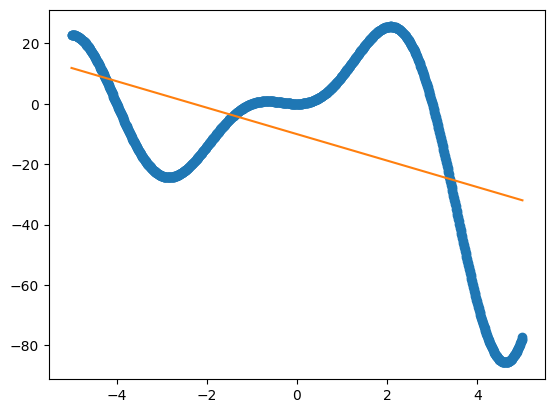

In [63]:
plt.plot(X_test[:,0], y_test, 'o')
plt.plot(x_temp[:,0], x_temp[:,0]*w_ridge[0] + w_ridge[1])

In [64]:
print(f"The RMSE on the test set using a ridge regression made from matrix multiplication is: {mean_squared_error(y_test, coef[0]*X_test + intercept, squared = False)}")

The RMSE on the test set using a ridge regression made from matrix multiplication is: 26.754437037853315


C:\Users\Davide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Conclusion: using sklearn module or just matrix multiplication will gain the same result.
            Now, let's try a non linear approch.

### Fit a kernel ridge regression model with gaussian


Before continuing, let's write down the various kernel formulas:
- Polynomial: $k(x_1,x_2) = (x_1^T \cdot x_2 +1 )^p $
- Gaussian: $k(x_1, x_2) = \exp \bigg( - \frac{||x_1-x_2||^2}{2p^2} \bigg)$
- Linear: $k(x_1,x_2) = x_1^T \cdot x_2 $

In [11]:
# This function will allow us to compute a kernel result operation based on what method and parameter we prefer. 
# Note: The polynomial with param 1 is equal to gaussian of param 0.1 that is equal to linear.

def kernelFunc(x1, x2, kernel_type, param):
    '''
    In:  x1 = i-th row;
         x2 = j-th col;
         kernel_type = type of kernel to use;
         param = value of the parameter to use.
    Out: the result of the kernel operations on the x1 and x2.

    This function compute the value based on a chosen kernel
    '''

    if kernel_type == 'polynomial':
        return pow((1 + np.dot(x1, x2)), param)

    elif kernel_type == 'gaussian':
        return np.exp(-(np.dot(x1-x2,x1-x2) /2*param**2))

    # Linear Kernel, same as not using Kernels at all
    elif kernel_type == 'linear':
        return np.dot(x1,x2)

In [84]:
def predict(x, y, kernel_type = 'gaussian', param = 1):
    '''
    In:  x = feature of dataset;
         y = label of the dataset;
         kernel_type = type of kernel to use;
         param = value of the parameter to use.
    Out: x_pred = predected feature;
         y_pred = predected label.

    This function takes care of driving a ridge regression using a specific 
    type of kernel of our choice and then returning the predicted features 
    and labels with the coefficients obtained.
    '''
    # We rearrange the x matrix adding a column only made out of ones. That help us with the bias problem on the y-axis.
    x = np.stack([x[:,0], np.ones(x.shape[0])], axis=1).reshape(-1,2)

    # We could just call the kernel function every time, instead we store the solutions in this matrix to save some computations
    K = np.zeros((x.shape[0], x.shape[0]))

    # We just computer the kerne operation for every elemnt of the matrix K
    for i, row in enumerate(K):
        for j, col in enumerate(K.T):
            K[i,j] = kernelFunc(x[i,:], x[j,:], kernel_type, param)

    # calculate the inverse of K with ridge regression, then the weights
    a = np.linalg.inv(K + 0.1 * np.eye(K.shape[0]))
    w = np.dot(y.reshape(1,-1),a)

    # and empy matrix for the predected X
    x_pred = np.linspace(-5, 5, test_points)

    # same as before, add column of ones to represent the constant b
    x_pred = np.stack([x_pred, np.ones(x_pred.shape[0])], axis=1).reshape(-1,2)
    y_pred = np.zeros(x_pred.shape[0])

    for i, x_p in enumerate(x_pred):
        k = np.zeros(x.shape[0])
        for j, row in enumerate(k):
            k[j] = kernelFunc(x_p, x[j,:], kernel_type, param)
        y_pred[i] = np.dot(w,k)

    return x_pred, y_pred

So, first a gaussian kernel using a param equal to 1.

C:\Users\Davide\AppData\Local\Temp\ipykernel_10648\3727145697.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = np.dot(w,k)


Text(0.5, 1.0, 'Gaussian ridge regression with param = 1')

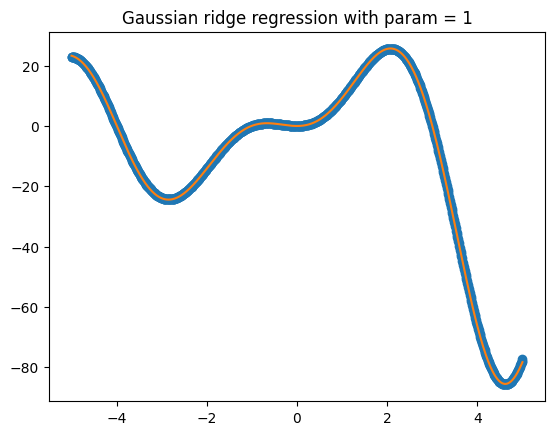

In [100]:
kernel_type = 'gaussian'
param = 1

x_pred, y_pred = predict(X_train, y_train, kernel_type, param)

plt.plot(X_test, y_test, 'o')
plt.plot(x_pred[:,0], y_pred)
plt.title("Gaussian ridge regression with param = 1")


In [95]:
print(f"The RMSE on the test set using a gaussian ridge regression is: {mean_squared_error(y_test, y_pred, squared = False)}")

The RMSE on the test set using a kernel ridge regression: 0.10587295795498074


C:\Users\Davide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The RMSE went from 26 down to below 0.  
Not bad.

### Fit a kernel ridge regression model with polynomial

Now, with the polynomial kernel and parameter equal to 2.  
Note: not equal to 1 cause it will be a linear kernel.

C:\Users\Davide\AppData\Local\Temp\ipykernel_10648\3727145697.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = np.dot(w,k)


Text(0.5, 1.0, 'Polynomial ridge regression with param = 2')

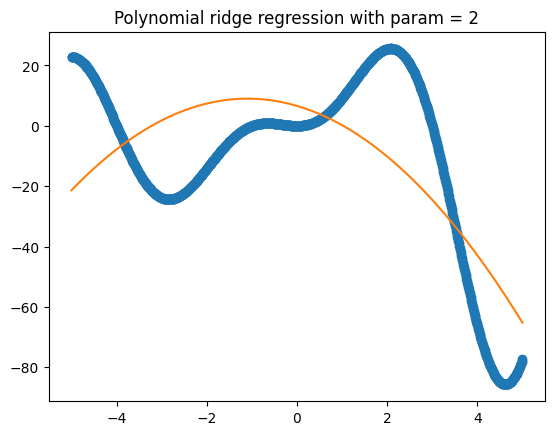

In [99]:
kernel_type = 'polynomial'
param = 2

x_pred, y_pred = predict(X_train, y_train, kernel_type, param)

plt.plot(X_test, y_test, 'o')
plt.plot(x_pred[:,0], y_pred)
plt.title("Polynomial ridge regression with param = 2")

In [97]:
print(f"The RMSE on the test set using a polynomial ridge regression is: {mean_squared_error(y_test, y_pred, squared = False)}")

The RMSE on the test set using a kernel ridge regression: 22.244156592589746


C:\Users\Davide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Gredy search for best parameters

I'm gonna start with the gaussian kernel first then with the polynomial using the RMSE. Then I'm gonna plot one last result using the best parameter founded.

In [106]:
# Define a function to fit and visualize kernel models

def gredy_test(x_train, x_test, y_train, y_test, kernel_type, param):
    '''
    In:  x_train = feature train set;
         x_test = feature test set;
         y_train = label train set;
         y_test = label test set;
         kernel_type = type of kernel to test;
         param = list containing all the parameter that need to be tested.
    Out: test_RMSE = a list with all the RMSE of every tested parameter.

    This function is used to test a list of parameters for a given kernel. 
    A kernel ridge regression is trained, the test set values ​​predicted and the RMSE calculated for each model. 
    After which the plot of two graphs is made: 
          - On the left shows the test set with all the regression lines obtained from each model; 
          - On the right the various RMSEs are shown as the value of the parameter varies.
    '''
    # Create a list of colors for plotting
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(param))))

    # Create a 2x2 grid of subplots for visualization
    fig, axs = plt.subplots(1, 2, figsize=(10, 8))

    # Set titles for subplots
    axs[0].set_title('Test Set Predictions')
    axs[1].set_title('Test Set RMSE')

    # Set labels for axes
    axs[0].set_xlabel("x test")
    axs[0].set_ylabel("y")
    axs[0].set_ylim([-100, 40])

    axs[1].set_xlabel("Param value")
    axs[1].set_ylabel("Test RMSE")

    # Scatter plot of test data points
    axs[0].scatter(X_test, y_test, c='k', label="y test")

    # Lists to store train and test RMSE for each parameter
    test_RMSE = []

    for k in range(0, len(param)):
        c = next(colors)

        x_pred, y_pred = predict(X_train, y_train, kernel_type, param[k])

        # Scatter plot of kernel predictions
        axs[0].scatter(x_pred[:,0], y_pred, color=c, label="deg: {}".format(param[k]), s=1)

        # Compute train and test RMSE for the k-th parameter
        # use sklearn to compute the error
        iter_test_RMSE = mean_squared_error(y_test, y_pred, squared = False)

        test_RMSE.append(iter_test_RMSE)

        # Plot RMSE values for each degree
        axs[1].plot(k + 1, iter_test_RMSE, color=c, label="param: {}".format(param[k]), marker='D', markersize=12,
                       markeredgecolor='black', markeredgewidth=3)

    # Plot dashed lines to interpolate RMSE measures
    axs[1].plot(range(1, len(param) + 1), test_RMSE, 'k--')

    # Add legends to the plots
    axs[1].legend(loc="upper right", bbox_to_anchor=(1.2, 1.01), prop={'size': 12})

    # Return the test RMSE lists
    return test_RMSE

C:\Users\Davide\AppData\Local\Temp\ipykernel_10648\3727145697.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = np.dot(w,k)
C:\Users\Davide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Davide\AppData\Local\Temp\ipykernel_10648\3727145697.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = np.dot(w,k)
C:\Users

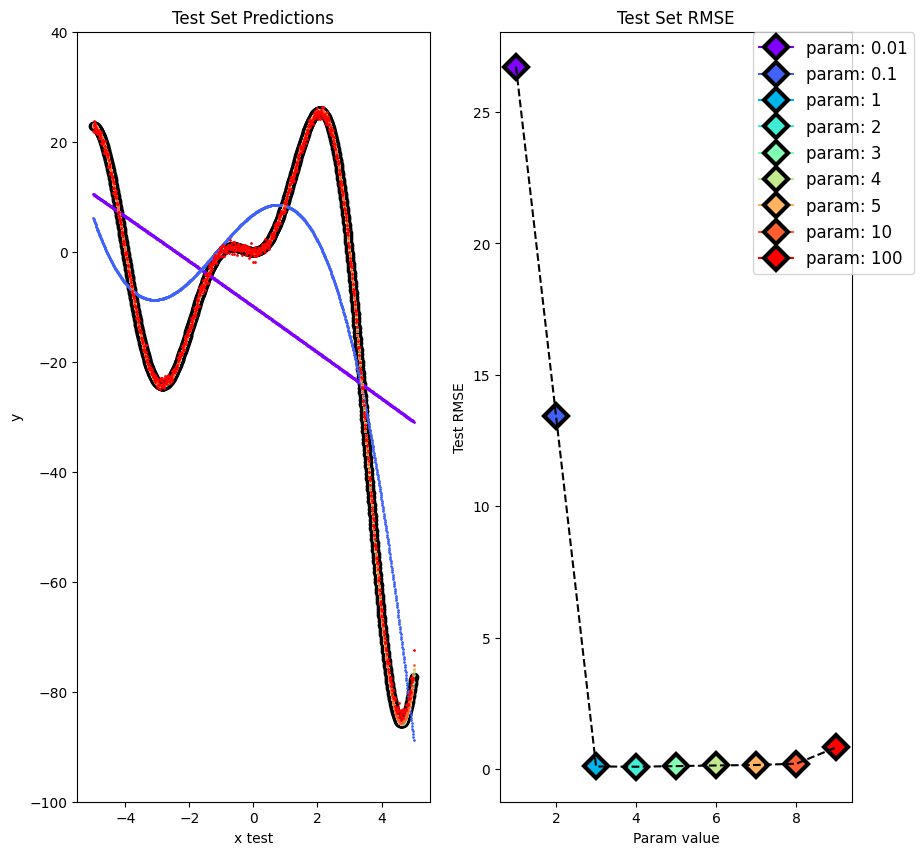

In [107]:
kernel_type = 'gaussian'
C = [0.01, 0.1, 1, 2, 3, 4, 5, 10, 100]

test_rmse = gredy_test(X_train, X_test, y_train, y_test, kernel_type, C)

In [108]:
print(f"All value obtained by the gredy search: {test_rmse}\nThe best value is: {min(test_rmse)} obtained with the parameter {C[test_rmse.index(min(test_rmse))]}")

All value obtained by the gridy search: [26.72369213977438, 13.43496678148916, 0.10587295795498074, 0.09540717686153567, 0.11862871066809258, 0.14373239361219659, 0.16167997367073278, 0.21065368157323447, 0.8330338734413484]
The best value is: 0.09540717686153567 obtained with the parameter 2


C:\Users\Davide\AppData\Local\Temp\ipykernel_10648\3727145697.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = np.dot(w,k)
C:\Users\Davide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Davide\AppData\Local\Temp\ipykernel_10648\3727145697.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = np.dot(w,k)
C:\Users

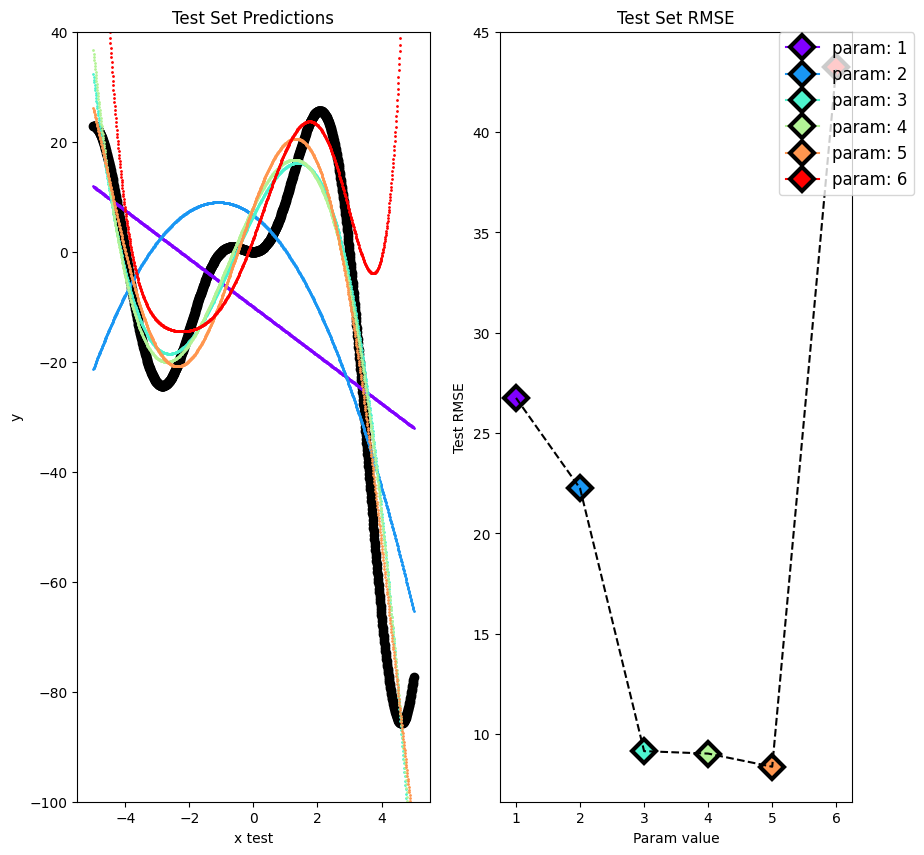

In [111]:
kernel_type = 'polynomial'
C = [1, 2, 3, 4, 5, 6]

test_rmse = gredy_test(X_train, X_test, y_train, y_test, kernel_type, C)

In [112]:
print(f"All value obtained by the gredy search: {test_rmse}\nThe best value is: {min(test_rmse)} obtained with the parameter {C[test_rmse.index(min(test_rmse))]}")

All value obtained by the gridy search: [26.754441197054053, 22.244156592589746, 9.150339457987391, 9.028733335172165, 8.37436296567974, 43.26123133354297]
The best value is: 8.37436296567974 obtained with the parameter 5


So, we tried some parameter and, as we expected, come to the conclusion that gaussian kernel is the best choice for the dataset. Overall, the RMSE are very likely to be small, unlike the polynomial kernel. The best param obtained from the gaussian is 2, with an $RMSE < 10^{-1}$. On the other hand, polynomial with a param equal to 5 and an $RMSE \sim {8}$. 
Note: I choose to stop with a pram = 6 with the polynomial cause the RMSE was skyrocketing to high value and with a param = 100 for the gaussian because the RMSE was not decreasing but 
but slightly increasing.

## 2. PCA
Using the training and test data sets created in the following cell, what you have to do is:
* Fit a PCA model;
* Fit a Kernel PCA model with a kernel of your choice.

For each subtask, plot a visual representation of the projections and verify the accuracy of that kernel on the test data set using SVM.

In [531]:
X, y = make_circles(n_samples=1000, noise=0.15, factor=0.2, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=0)

In [475]:
def plot(X, y, n_feature = 2, x_label = "", y_label = "", title = "", hyperplane = None):
    '''
    Just a function for make simple the plot
    '''
    for i in range(0,n_feature):
        for j in range(i,n_feature):
            if i != j:
                plt.figure(figsize=(8,6))
                plt.scatter(X[y==0, i], X[y==0, j], color='red', alpha=0.5)
                plt.scatter(X[y==1, i], X[y==1, j], color='blue', alpha=0.5)
                if hyperplane is not None:
                    plt.plot(X_test, -(hyperplane[0][i,-1]/hyperplane[0][j,-1]) * X_test - (hyperplane[1][-1]/hyperplane[0][j,-1]))
                    plt.ylim(np.min(X[:,j]),np.max(X[:,j]))
                    plt.xlim(np.min(X[:,i]),np.max(X[:,i])) 
                plt.title(title)
                plt.xlabel(x_label)
                plt.ylabel(y_label)

                plt.show()    

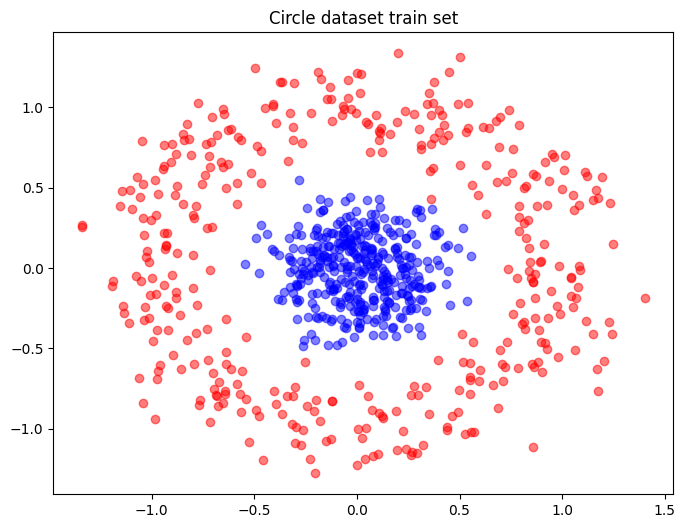

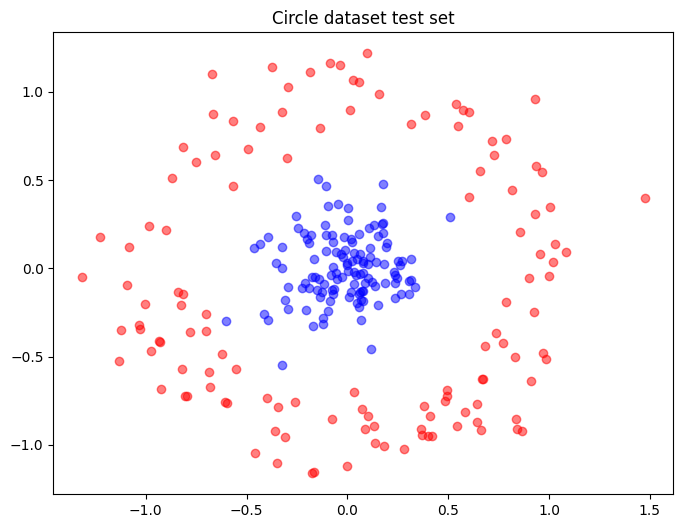

In [476]:
plot(X_train,y_train,title='Circle dataset train set')
plot(X_test,y_test,title='Circle dataset test set')

### Linear SVM

In [477]:
# loss function
def hingeFunction(z):
    return np.maximum(1-z,0)


def hingesubgrad(z):
    g = np.zeros(z.shape)
    g[z < 1] = -1
    return g

def ReghingeLoss(X, labels, w, lam):
    d = np.shape(X)[0]
    L = np.mean(np.maximum(np.ones(d) - labels*(X@w), 0)) + lam * norm(w,2)
    return L

def svmGrad(X, labels, w, lam):
    g1 = hingesubgrad(np.diag(labels)@(X@w))
    g2 = np.diag(labels)@X
    return g1.dot(g2) + 2*lam*w

def svm_training(X, labels, lam, Iter, gamma):

    W = np.zeros((X.shape[1], Iter))
    W[:,0] = np.random.normal(0,0.01,X.shape[1])
    L = np.zeros(Iter)

    for i in range(Iter-1):
        grad_w = svmGrad(X, labels, W[:,i], lam)
        W [:,i+1]= W[:,i] - gamma * grad_w
        L[i] = ReghingeLoss(X, labels, W[:,i], lam)
    return W, L

In [478]:
W, L = svm_training(X_train, y_train, lam=0, Iter=5000, gamma=0.0001)

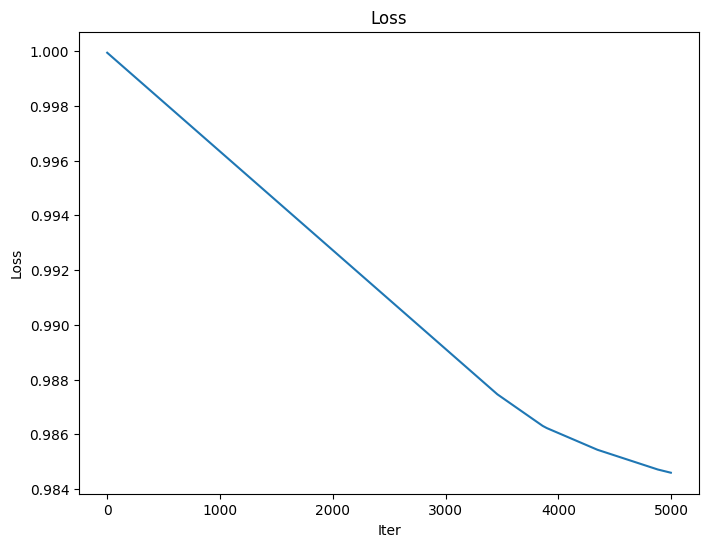

In [479]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(L[0:-2])
ax.set_title('Loss')
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')

plt.show()

In [480]:
# get SVM's predictions
def predlabels(X, w):
    supp = np.sign(X@w)
    supp[supp == -1] = 0
    return supp

# calculate accuracy
def acc(labels, predlabels):
    y = deepcopy(predlabels)
    y[y==-1] = 0
    return np.count_nonzero(labels == y)/len(labels)

In [481]:
y_pred = predlabels(X_test, W[:,-1])
acc(y_test,y_pred)

0.484

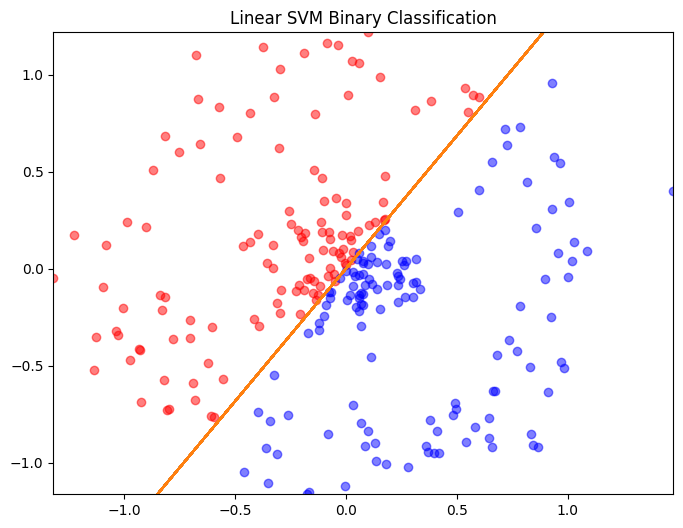

In [482]:
plot(X_test, y_pred, title='Linear SVM Binary Classification', hyperplane=[W,L])

### PCA model


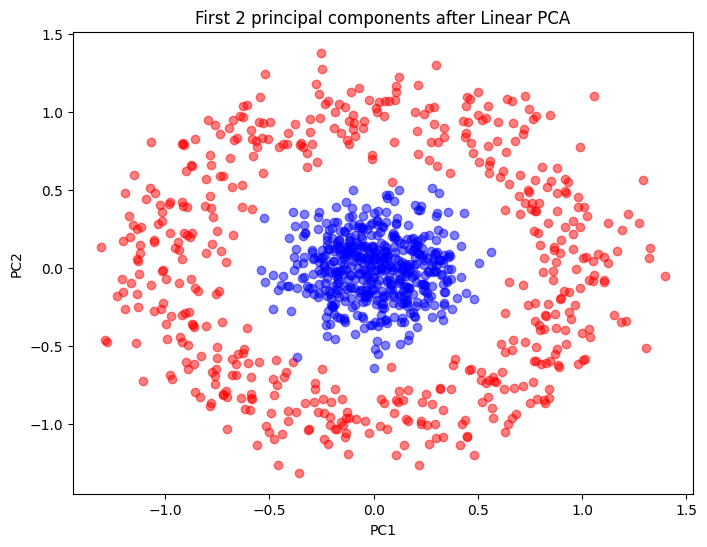

In [483]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
plot(X_spca, y, x_label='PC1', y_label='PC2', title='First 2 principal components after Linear PCA')

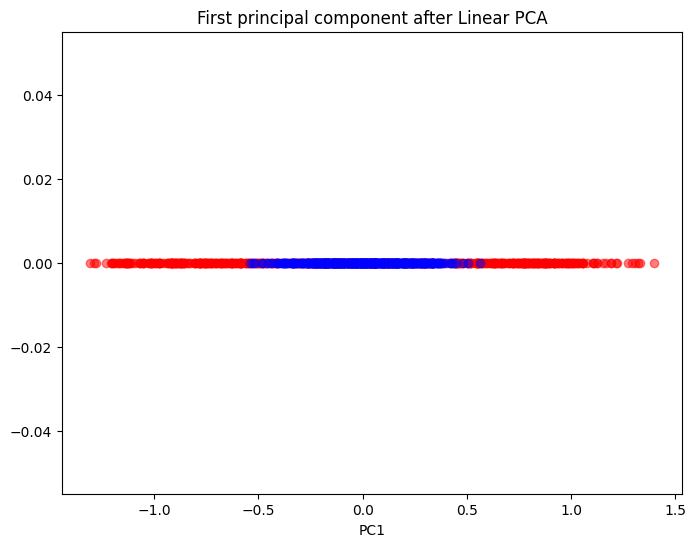

In [484]:
plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], np.zeros(X_spca[y==0, 0].shape), color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], np.zeros(X_spca[y==1, 0].shape), color='blue', alpha=0.5)

plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')

plt.show()

Now, let's train an linear SVM on the standard PCA and see how it goes.

In [485]:
X_train, X_test, y_train, y_test = train_test_split(X_spca, y, stratify = y, random_state=0)

W, L = svm_training(X_train, y_train, lam=0, Iter=5000, gamma=0.0001)

y_pred = predlabels(X_test, W[:,-1])
acc(y_test,y_pred)

0.484

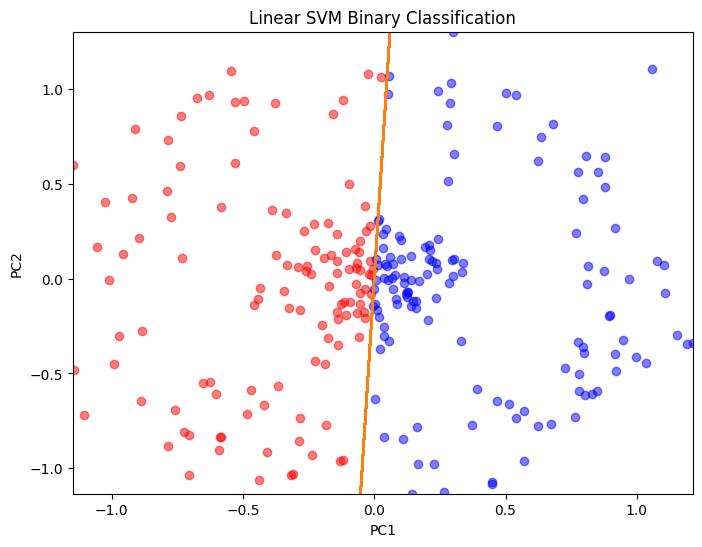

In [486]:
plot(X_test, y_pred, x_label='PC1', y_label='PC2', title='Linear SVM Binary Classification', hyperplane=[W,L])

### Kernel PCA model

In [487]:
# implement kernel PCA
def kpca(X, kernel_type, param, n_components = 2):
    '''
    In:  X = the entire dataset that need to be reduced;
         kernel_type = type of kernel to test;
         param = list containing all the parameter that need to be tested;
         n_components = the ammount of principal componenents that need to be computed.
    Out: X_kbr = the reduced dataset with n_components feature.

    This function takes care of taking a dataset and doing a reduction to n dimensions using kernel PCA,
    ''' 
    # Preparation
    N = X.shape[0]

    # Compute every value of matrix K using kernel function
    K = np.zeros((N,N))
    for i,xi in enumerate(X):
        for j, xj in enumerate(X):
            K[i,j] = kernelFunc(X[i,:], X[j,:], kernel_type, param)

    # Centering the matrix 
    In = np.ones((N,N)); In = In / N  # Matrix NxN with all 1/N value in it
    K = K - In.dot(K) - K.dot(In) + In.dot(K).dot(In)

    # Compute eigenvalue and vector from the centered matrix
    eigval, eigvecs = eigh(K)

    # Eigenvalues-based sorting by the most relevant feature and final matrix creation
    X_kbr = np.column_stack([-eigvecs[:,-i] for i in range(1,n_components+1)])

    return X_kbr


0.48


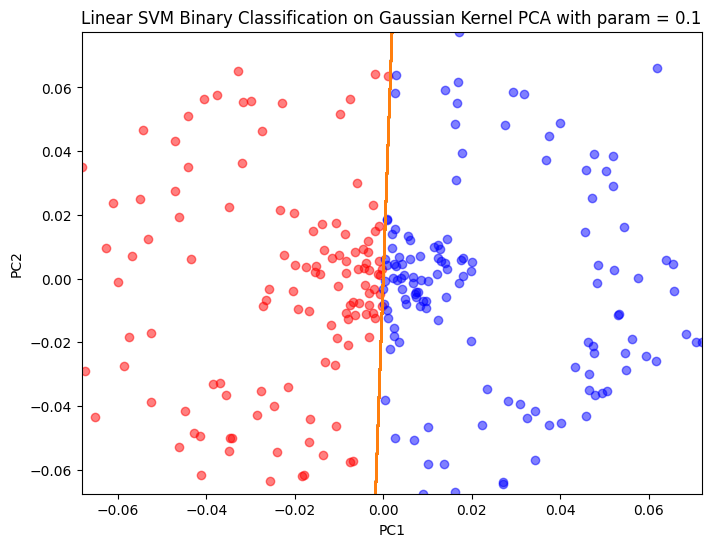

0.484


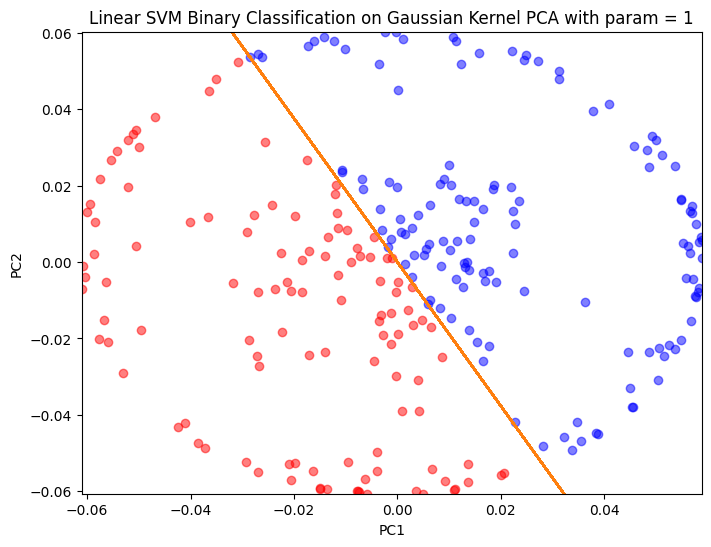

0.992


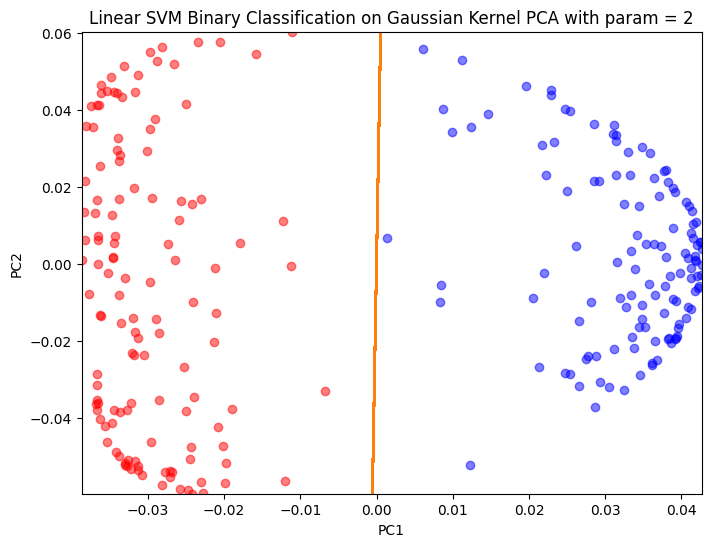

0.98


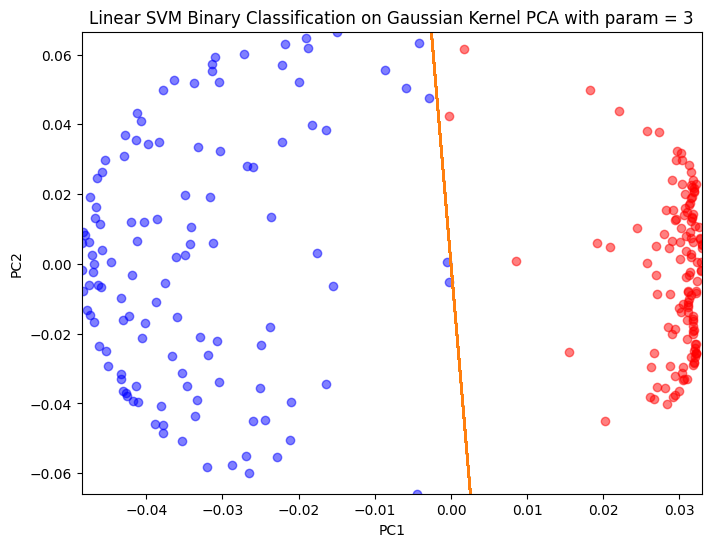

0.952


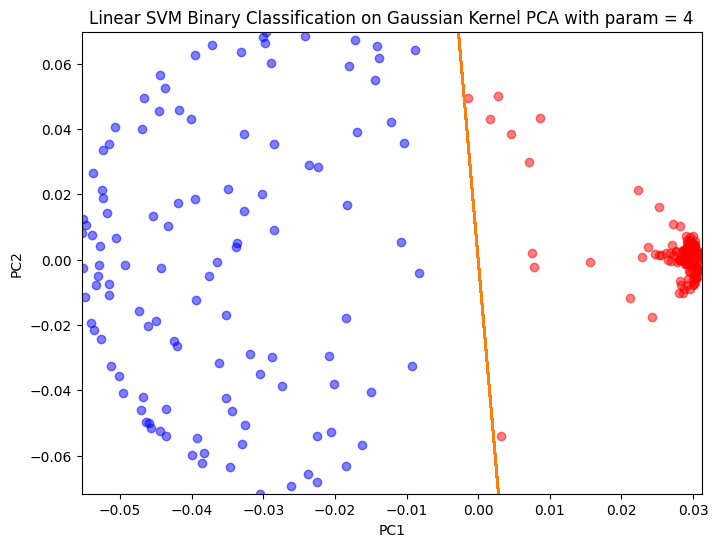

0.948


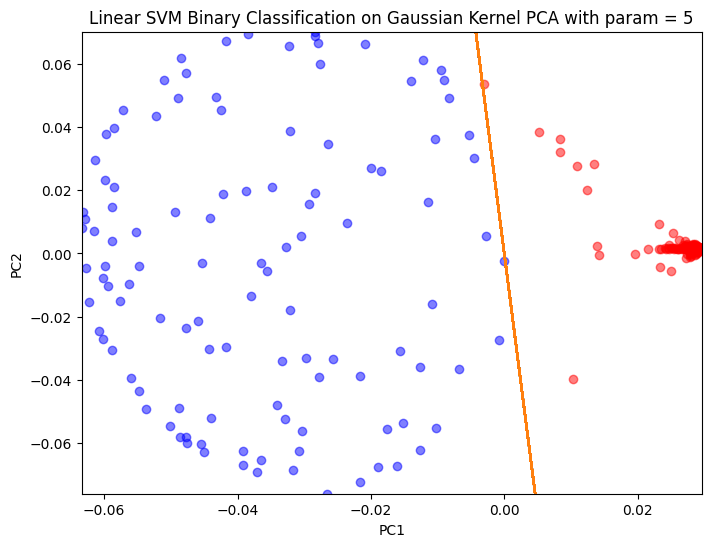

0.832


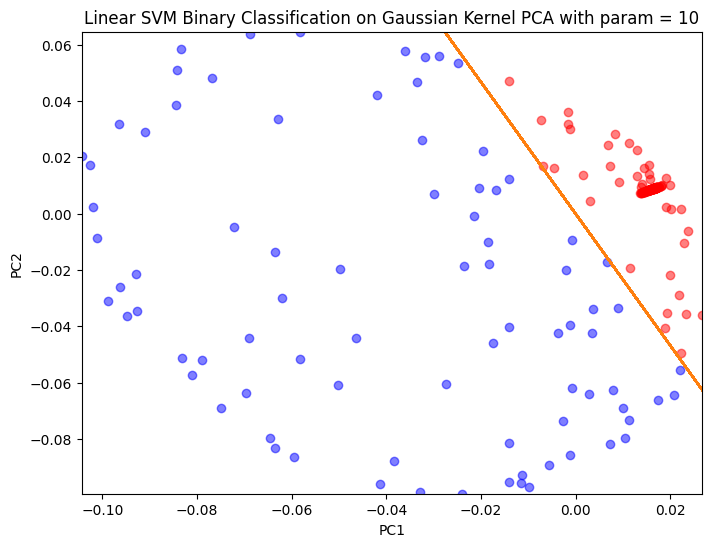

In [488]:
kernel_type = 'gaussian'
C = [0.1, 1, 2, 3, 4, 5, 10]

for j in C:

    X_kpca =  kpca(X, kernel_type, j, 2)
    X_train, X_test, y_train, y_test = train_test_split(X_kpca, y, stratify = y, random_state=0)

    W, L = svm_training(X_train, y_train, lam=0, Iter=5000, gamma=0.0001)

    y_pred = predlabels(X_test, W[:,-1])
    print(acc(y_test,y_pred))

    plot(X_test, y_pred, x_label='PC1', y_label='PC2', title=f'Linear SVM Binary Classification on Gaussian Kernel PCA with param = {j}', hyperplane=[W,L])

0.476


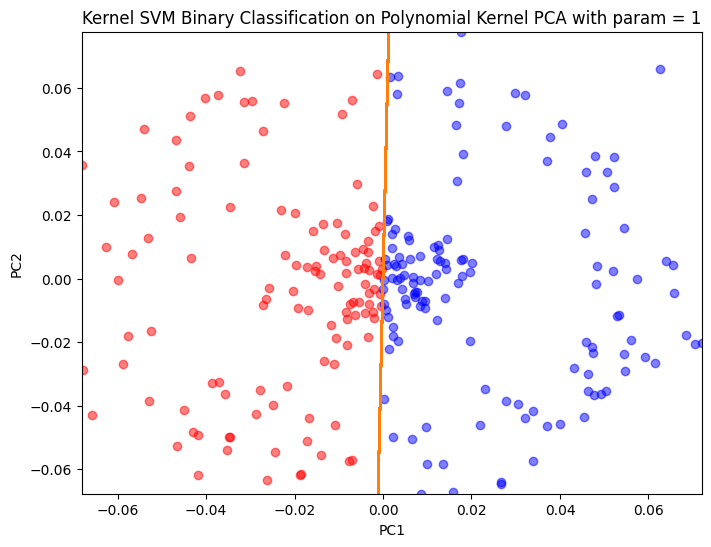

0.472


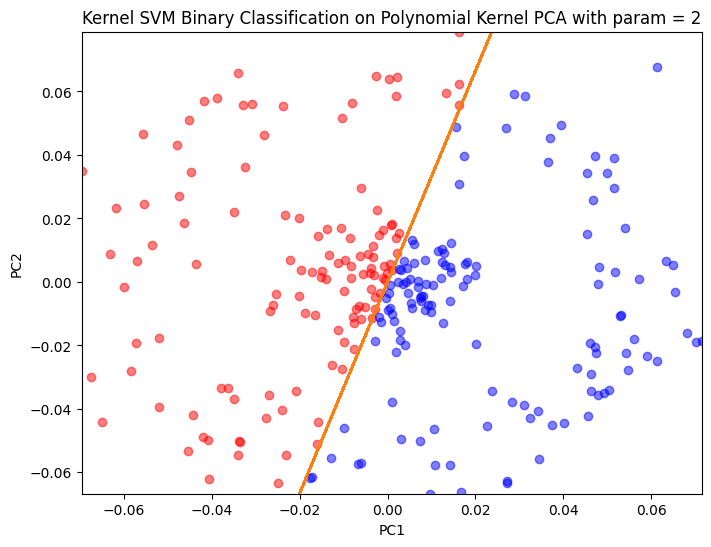

0.5


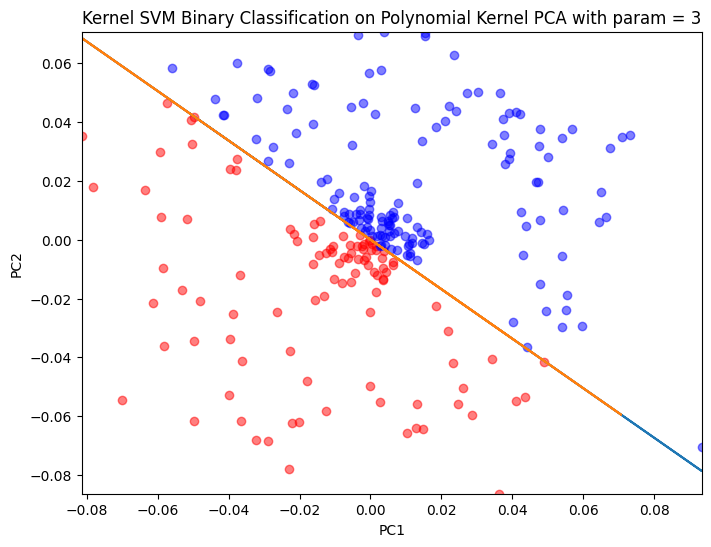

0.516


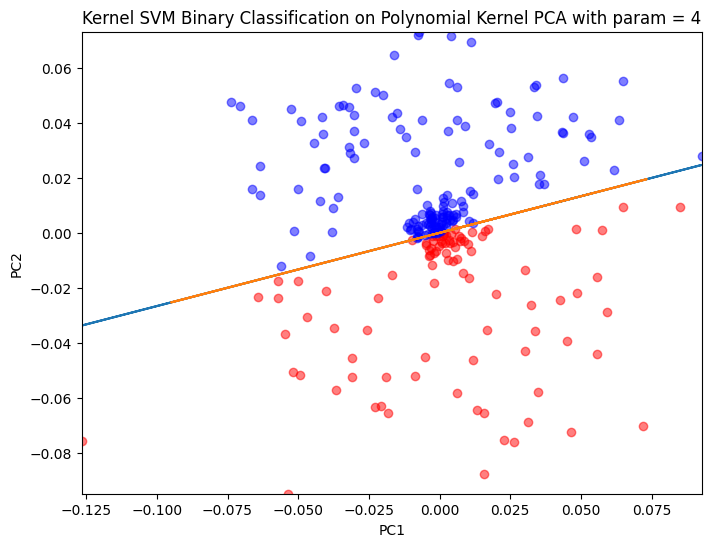

0.572


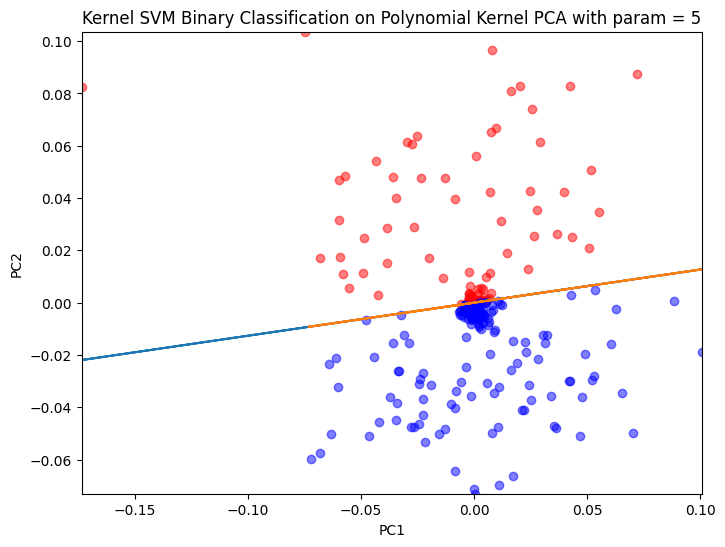

0.664


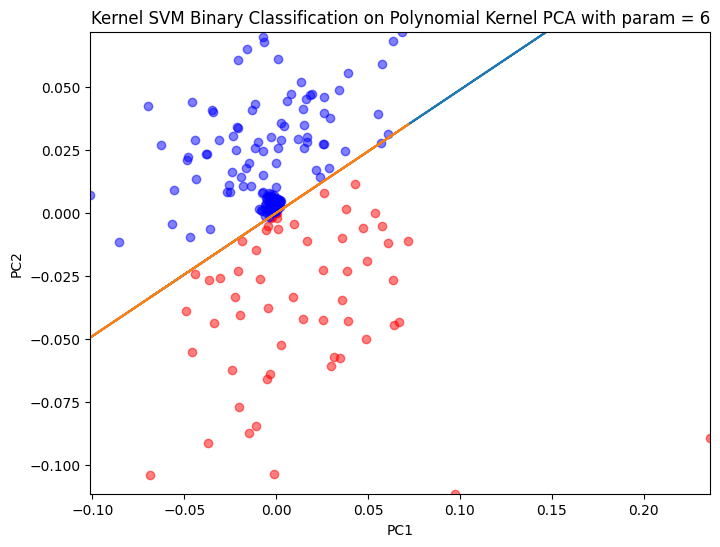

0.692


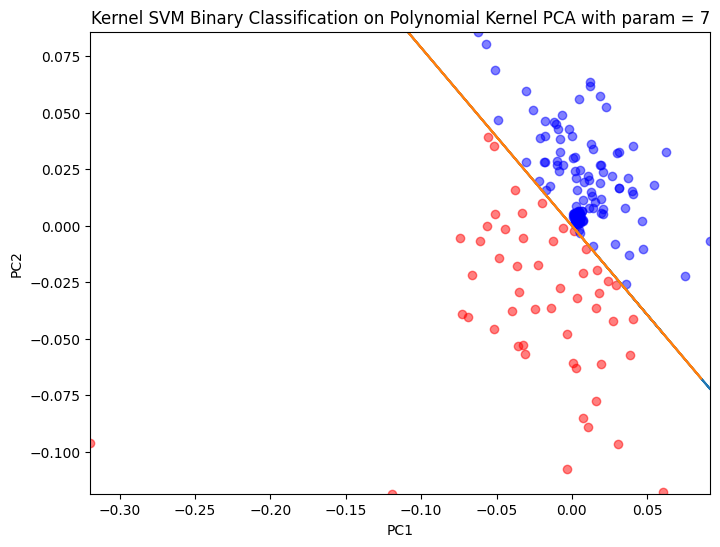

0.688


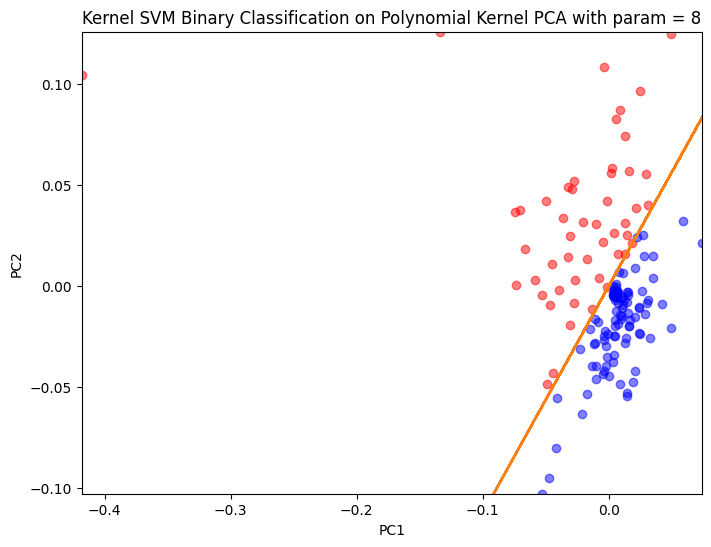

0.684


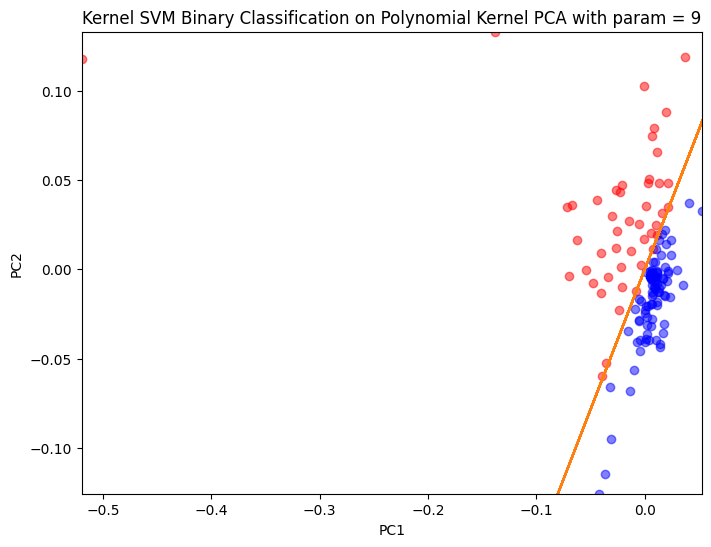

0.656


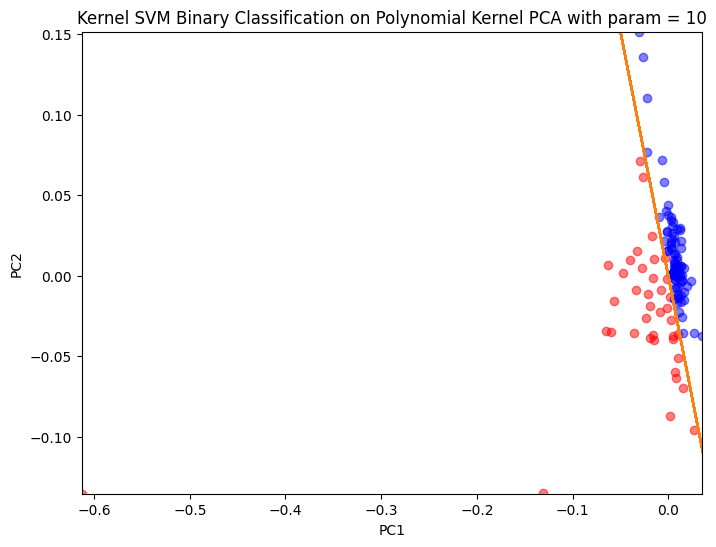

In [534]:
kernel_type = 'polynomial'
C = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for j in C:

    X_kpca =  kpca(X, kernel_type, j, 2)
    X_train, X_test, y_train, y_test = train_test_split(X_kpca, y, stratify = y, random_state=0)

    W, L = svm_training(X_train, y_train, lam=0, Iter=5000, gamma=0.0001)

    y_pred = predlabels(X_test, W[:,-1])
    print(acc(y_test,y_pred))
 
    plot(X_test, y_pred, x_label='PC1', y_label='PC2', title=f'Kernel SVM Binary Classification on Polynomial Kernel PCA with param = {j}', hyperplane=[W,L])

1) We tried to train a linear SVM on the circle dataset. As we expect, very poorly classification. The accuracy obtained on the test set was ~50%.
2) We then implemented standard PCA, reduce the dataset and train a second model, still linear SVM. Same result because the dataset is not linear. So PCA act very poorly and doesn't do much.
3) Finally we start to use a Kern PCA and repeat the process. Done it. With gaussian kernel we obtain an astonishing 98% of accuracy (param = 3), but polynomial came close to ~70% of accuracy (param = 7).  
Conclusion: a well chosen kernel mixed with PCA make the difference even with a linearl method.

## 3. PCA pt.2
Repeat the last point of the previous task with a dataset made with ```sklearn.datasets.make_classification()```. Find the best kernel, and comment on your discoveries in the report. What differences do you see with the previous data set?

### Simple dataset

The first dataset will be a well separated group of clusters with 3 feature. A simple job for our linear SVM.

In [490]:
X,y = make_classification(n_samples=3000, n_features=3, n_informative=3, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, class_sep=5, flip_y=0, weights=[0.5,0.5], random_state=17)

In [491]:
dataset = pd.DataFrame(X)

dataset.columns = ['X1', 'X2', 'X3']

dataset['y'] = y

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      3000 non-null   float64
 1   X2      3000 non-null   float64
 2   X3      3000 non-null   float64
 3   y       3000 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 82.2 KB


In [492]:
dataset['y'].value_counts()

y
0    1500
1    1500
Name: count, dtype: int64

In [493]:
dataset.head()

X1        X2        X3  y
0 -4.161161  4.006785 -5.182647  0
1  2.718078 -4.305552  7.621152  1
2 -5.004877  2.723996 -4.330299  0
3 -6.119771  5.619798 -4.514601  0
4  4.518503 -5.531276  6.102170  1

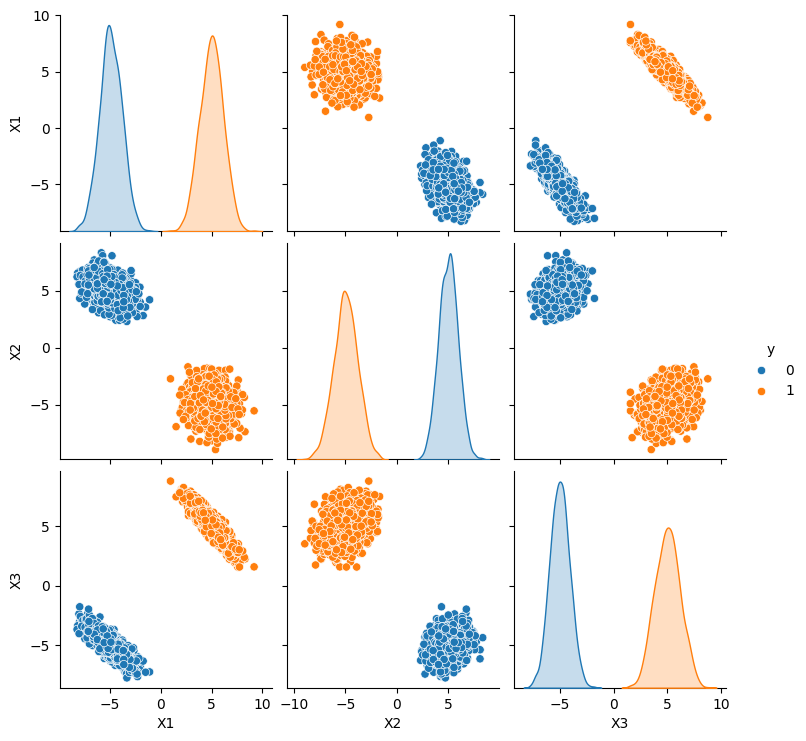

In [494]:
pairplot(dataset, hue = 'y')

In [495]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

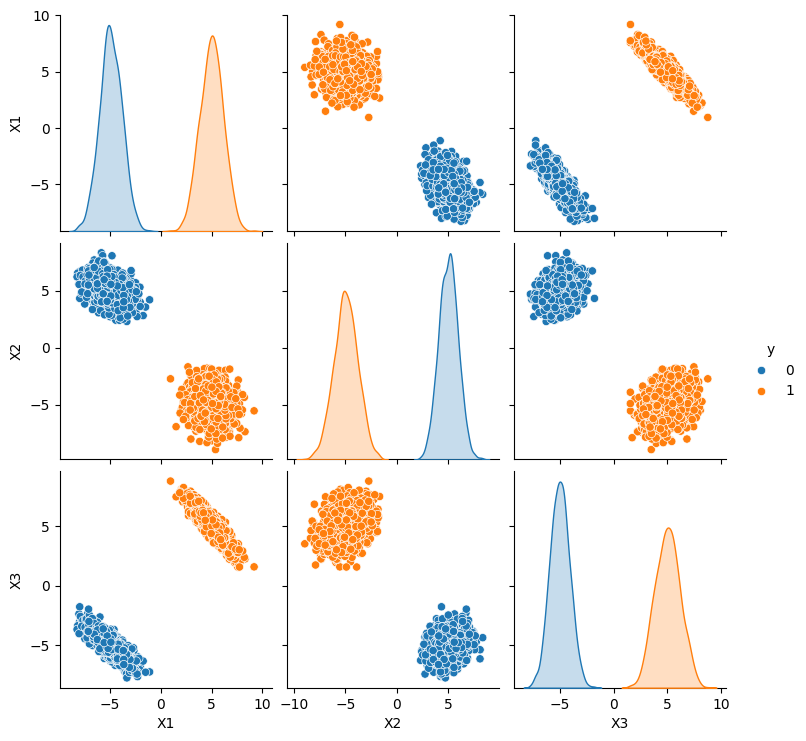

In [496]:
pairplot(dataset, hue = 'y')

In [497]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y, random_state=0)

In [498]:
W, L = svm_training(X_train, y_train, lam=0, Iter=500, gamma=0.0001)

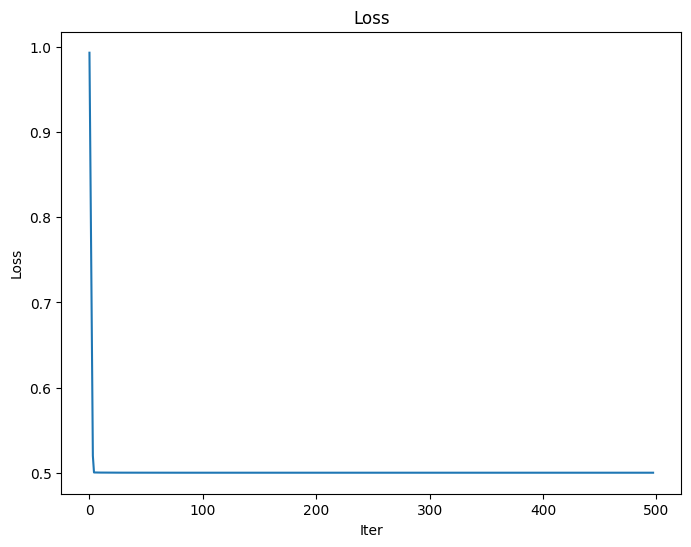

In [499]:
# plot loss

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(L[0:-2])
ax.set_title('Loss')
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')

plt.show()

In [500]:
y_pred = predlabels(X_test, W[:,-1])
acc(y_test,y_pred)

1.0

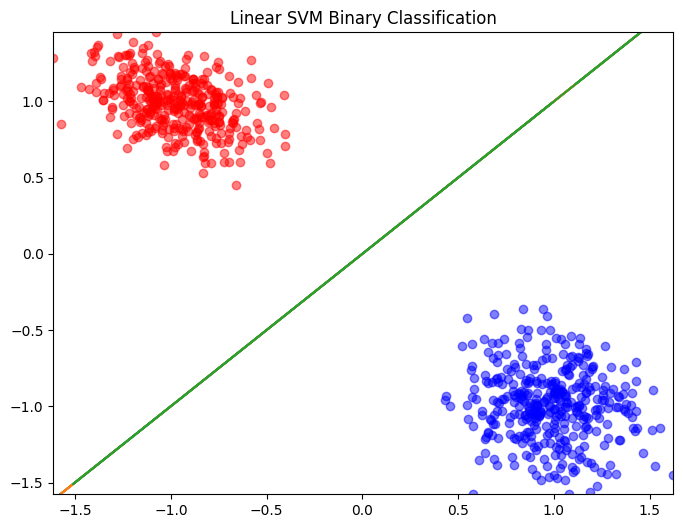

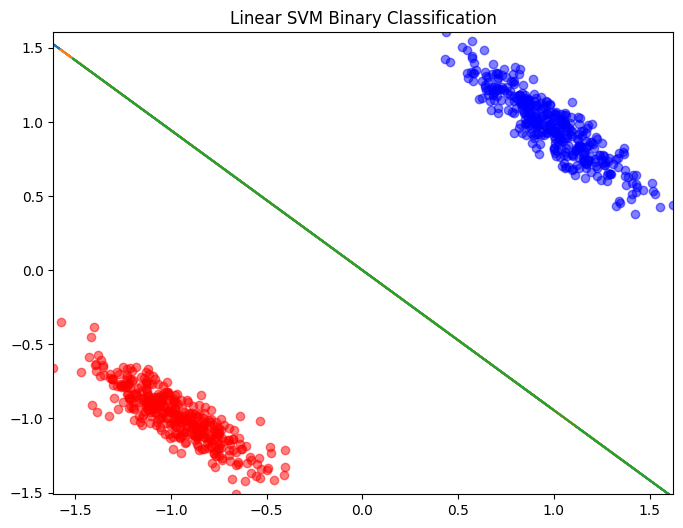

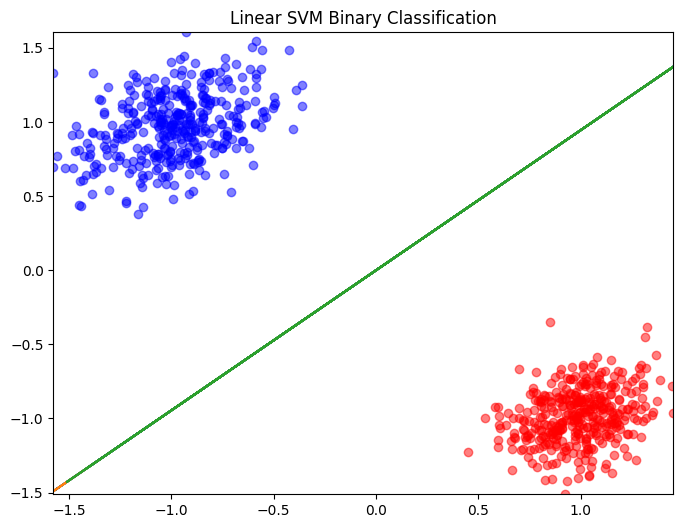

In [501]:
plot(X_test, y_pred, n_feature=3, title="Linear SVM Binary Classification", hyperplane=[W,L])

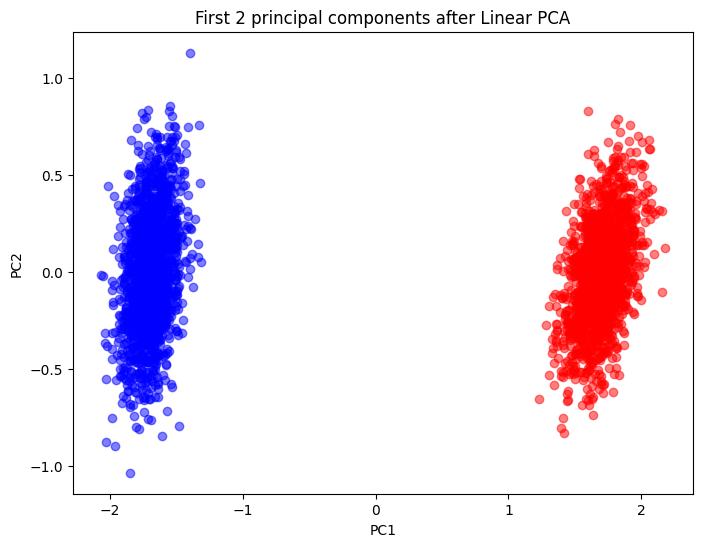

In [502]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X_scaled)

plot(X_spca, y, x_label='PC1', y_label='PC2', title='First 2 principal components after Linear PCA')

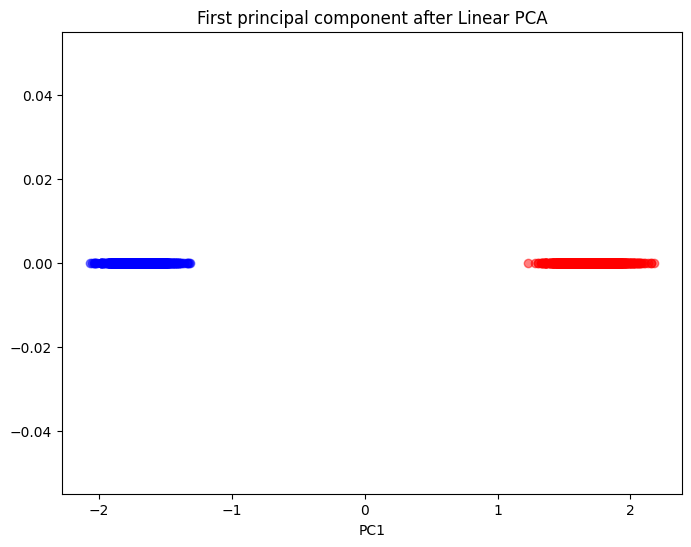

In [503]:
plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], np.zeros(X_spca[y==0, 0].shape), color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], np.zeros(X_spca[y==1, 0].shape), color='blue', alpha=0.5)

plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')

plt.show()

In [504]:
X_train_spca, X_test_spca, y_train_spca, y_test_spca = train_test_split(X_spca, y, stratify = y, random_state=0)

W_spca, L_spca = svm_training(X_train_spca, y_train_spca, lam=0, Iter=300, gamma=0.0001)

y_pred_spca = predlabels(X_test_spca, W_spca[:,-1])
acc(y_test_spca,y_pred_spca)

1.0

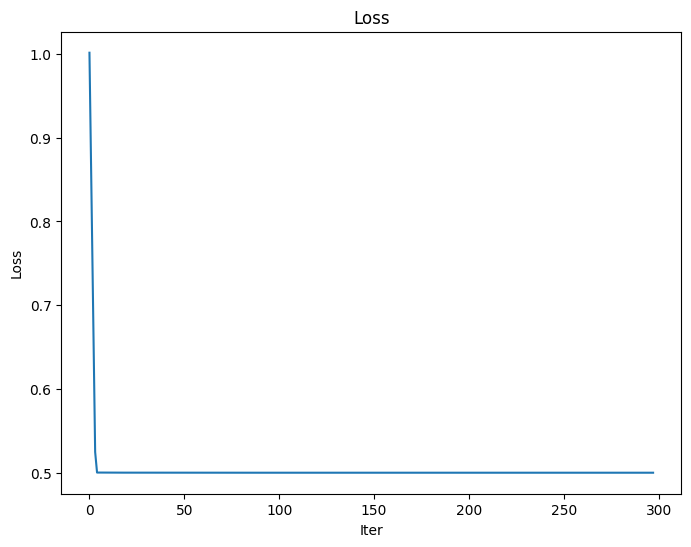

In [505]:
# plot loss

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(L_spca[0:-2])
ax.set_title('Loss')
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')

plt.show()

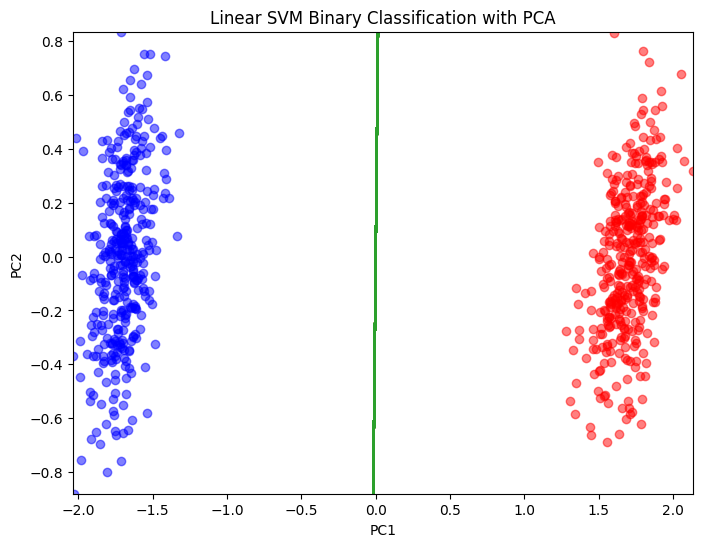

In [506]:
plot(X_test_spca, y_pred_spca, x_label='PC1', y_label='PC2', title='Linear SVM Binary Classification with PCA', hyperplane=[W_spca,L_spca])

1.0


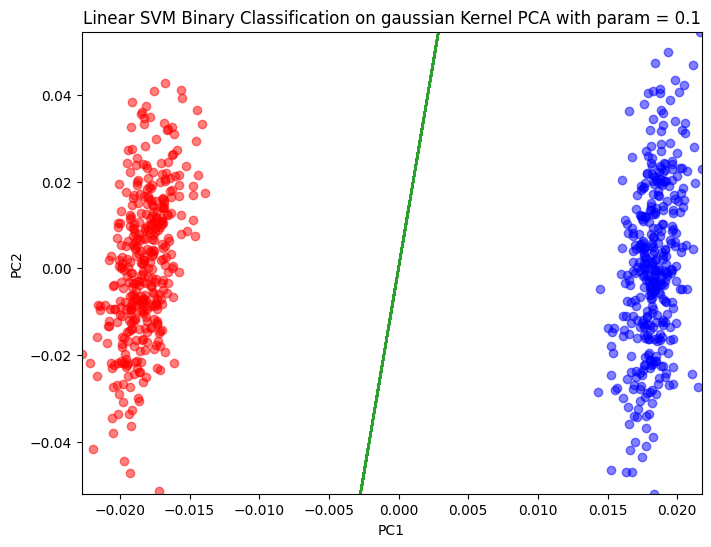

1.0


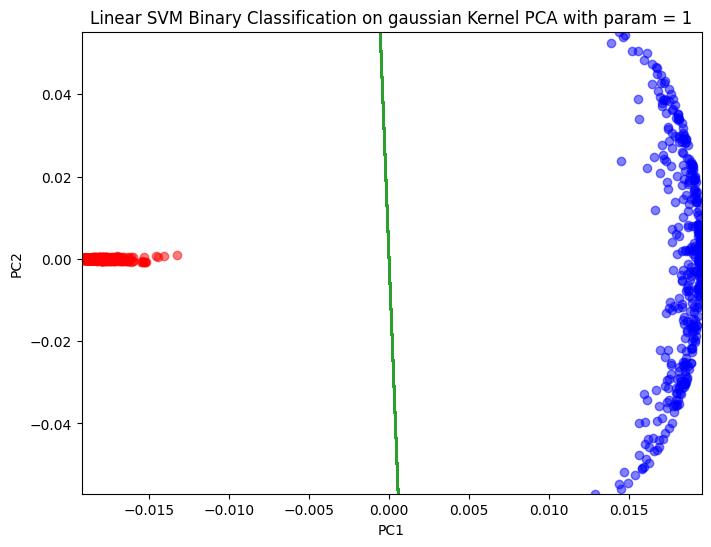

1.0


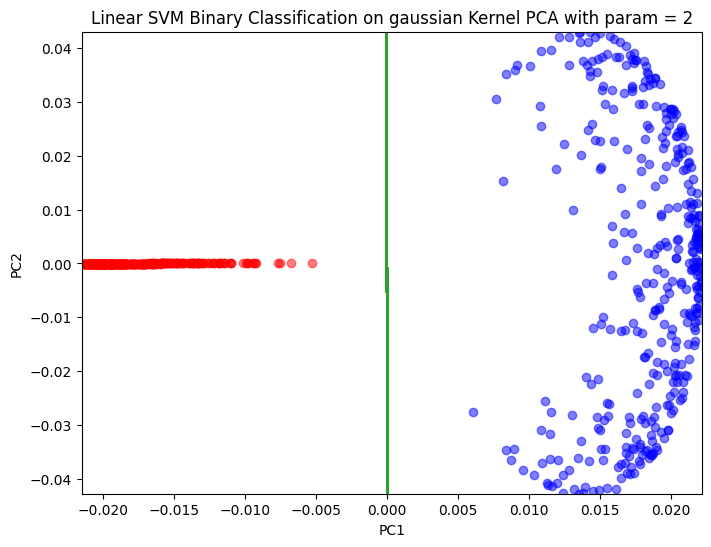

1.0


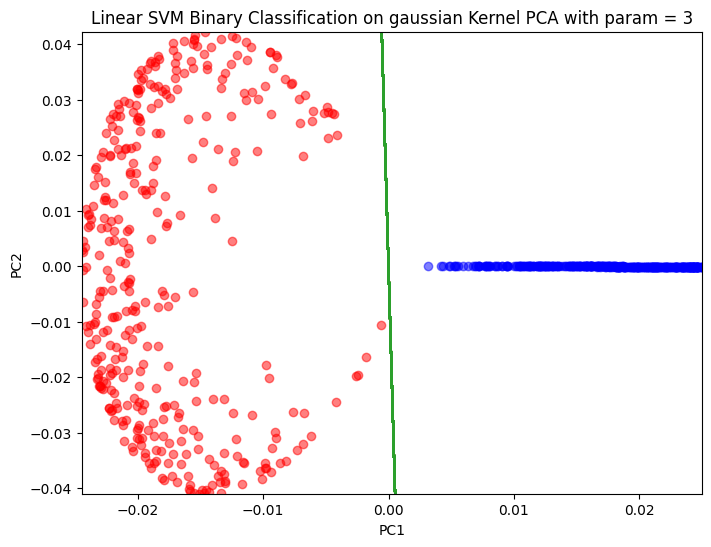

In [507]:
kernel_type = 'gaussian'
C = [0.1, 1, 2, 3]

for j in C:

    X_kpca =  kpca(X_scaled, kernel_type, j, 2)
    X_train_kpca, X_test_kpca, y_train_kpca, y_test_kpca = train_test_split(X_kpca, y, stratify = y, random_state=0)

    W_kpca, L_kpca = svm_training(X_train_kpca, y_train_kpca, lam=0, Iter=500, gamma=0.0001)

    y_pred_kpca = predlabels(X_test_kpca, W_kpca[:,-1])
    print(acc(y_test_kpca,y_pred_kpca))

    plot(X_test_kpca, y_pred_kpca, x_label='PC1', y_label='PC2', title=f'Linear SVM Binary Classification on gaussian Kernel PCA with param = {j}', hyperplane=[W_kpca,L_kpca])

1.0


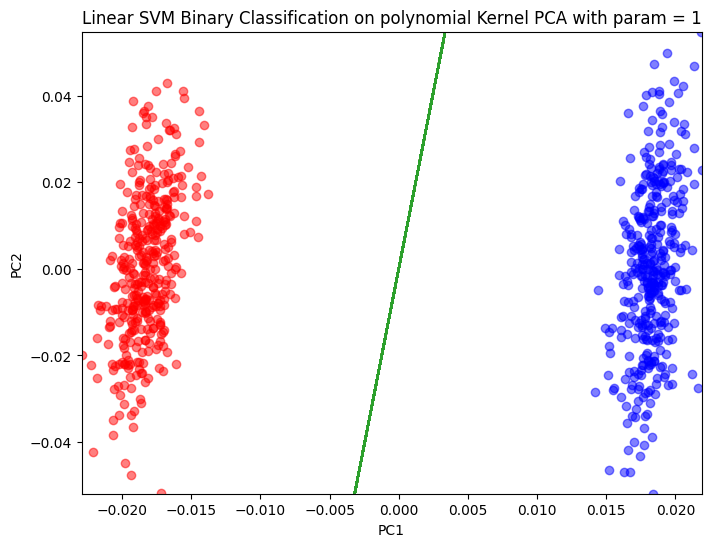

1.0


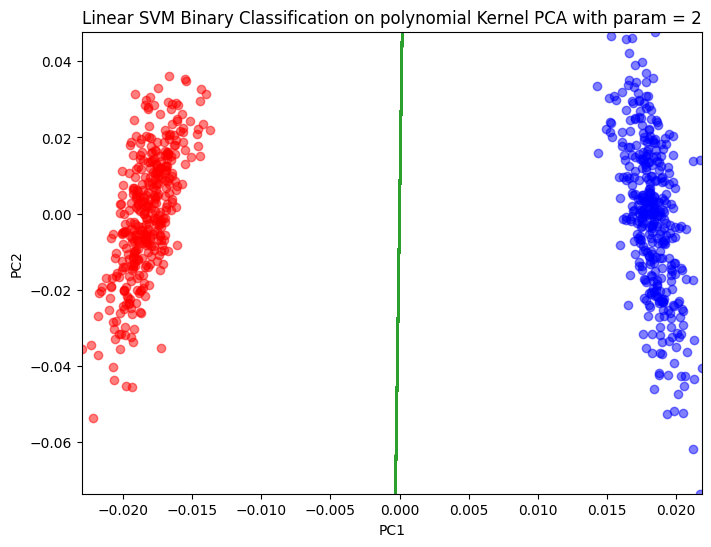

1.0


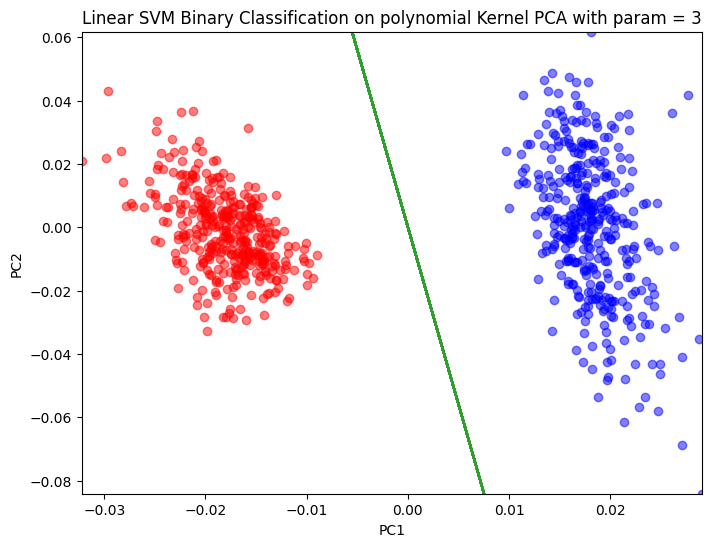

1.0


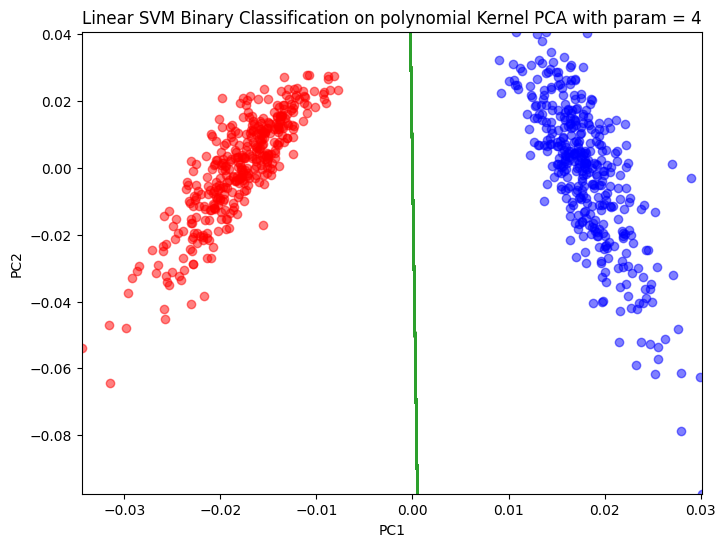

In [508]:
kernel_type = 'polynomial'
C = [1, 2, 3, 4]

for j in C:

    X_kpca =  kpca(X_scaled, kernel_type, j, 2)
    X_train_kpca, X_test_kpca, y_train_kpca, y_test_kpca = train_test_split(X_kpca, y, stratify = y, random_state=0)

    W_kpca, L_kpca = svm_training(X_train_kpca, y_train_kpca, lam=0, Iter=500, gamma=0.0001)

    y_pred_kpca = predlabels(X_test_kpca, W_kpca[:,-1])
    print(acc(y_test_kpca,y_pred_kpca))

    plot(X_test_kpca, y_pred_kpca, x_label='PC1', y_label='PC2', title=f'Linear SVM Binary Classification on polynomial Kernel PCA with param = {j}', hyperplane=[W_kpca,L_kpca])

As we expected, the linear SVM, linear SVM + PCA and linear SVM + kernel PCA give the same optimal model. Let's try a more complicated dataset.

### Harder dataset

Let's try an harder dataset. With low separation between the clusters and more noise.

In [509]:
X,y = make_classification(n_samples=3000, n_features=3, n_informative=3, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, class_sep=0.5, flip_y=0.2, weights=[0.5,0.5], random_state=17)

In [510]:
dataset = pd.DataFrame(X)

dataset.columns = ['X1', 'X2', 'X3']

dataset['y'] = y

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      3000 non-null   float64
 1   X2      3000 non-null   float64
 2   X3      3000 non-null   float64
 3   y       3000 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 82.2 KB


In [511]:
dataset['y'].value_counts()

y
1    1508
0    1492
Name: count, dtype: int64

In [512]:
dataset.head()

X1        X2        X3  y
0 -1.774691  2.507902 -1.079869  1
1  2.076046 -1.072731 -1.221227  1
2 -1.784675  0.693594  2.840853  0
3 -2.097703  0.306805  0.940789  0
4  0.267901  0.657480 -1.116426  1

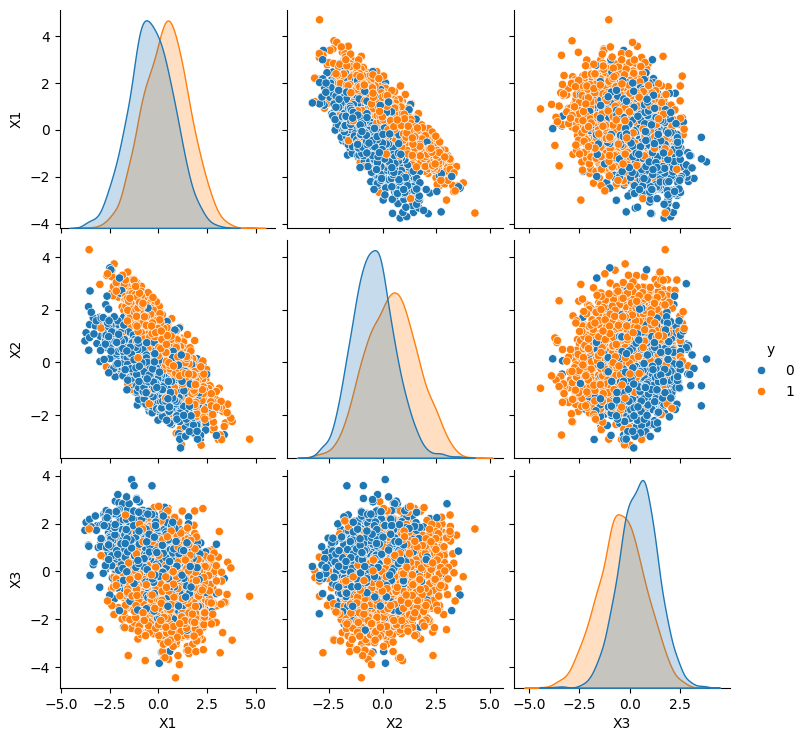

In [513]:
pairplot(dataset, hue = 'y')

In [514]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

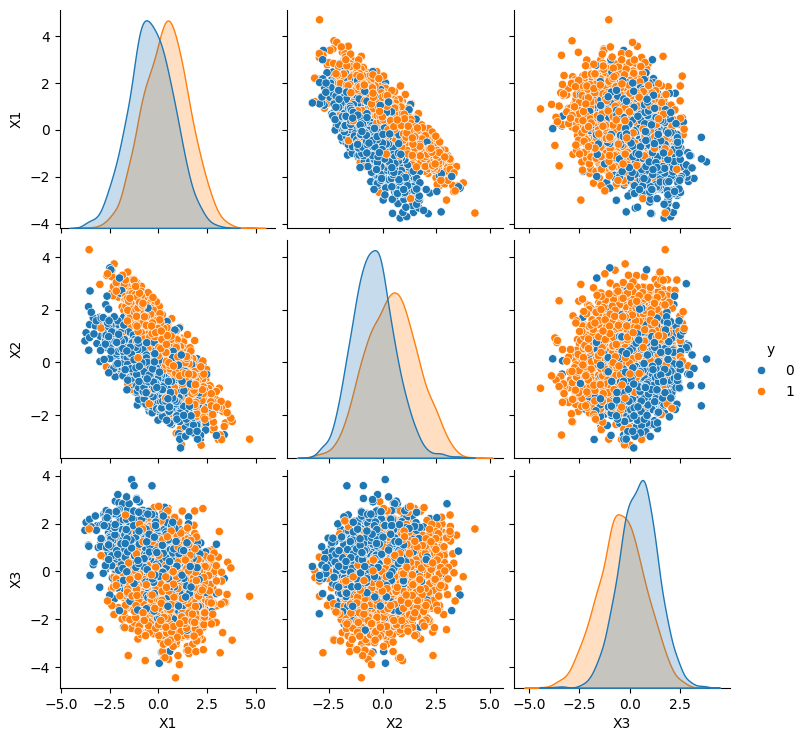

In [515]:
pairplot(dataset, hue = 'y')

In [516]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y, random_state=0)

In [517]:
W, L = svm_training(X_train, y_train, lam=0, Iter=500, gamma=0.0001)

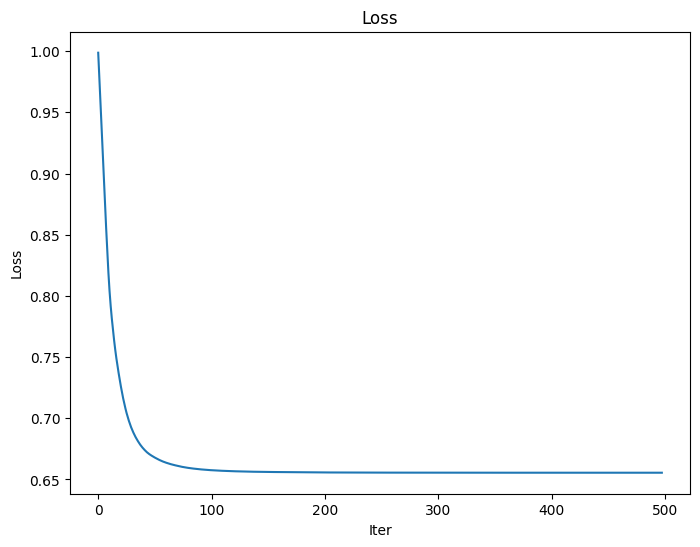

In [518]:
# plot loss

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(L[0:-2])
ax.set_title('Loss')
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')

plt.show()

In [519]:
y_pred = predlabels(X_test, W[:,-1])
acc(y_test,y_pred)

0.8933333333333333

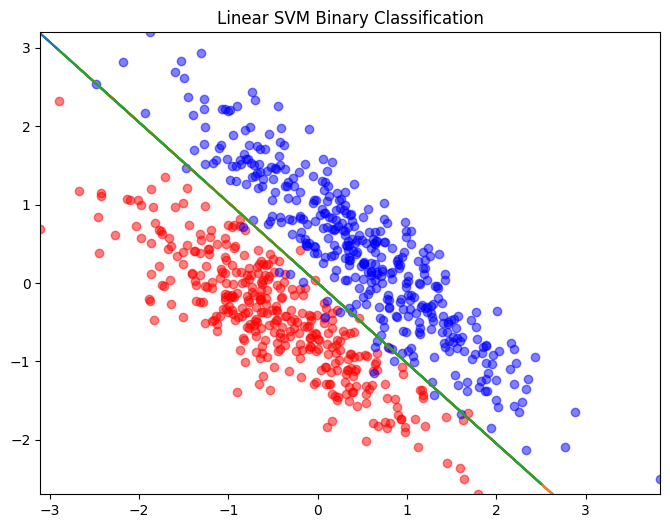

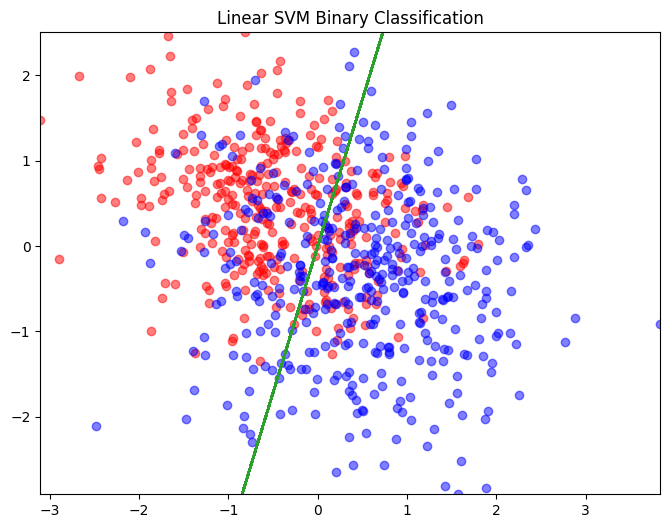

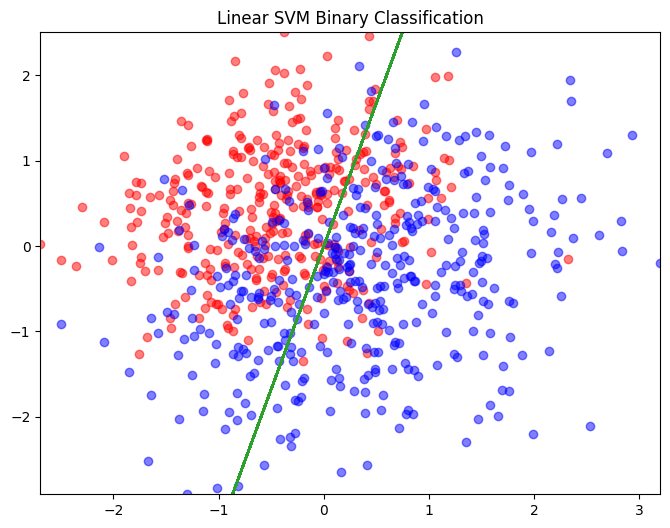

In [520]:
plot(X_test, y_pred, n_feature=3, title="Linear SVM Binary Classification", hyperplane=[W,L])

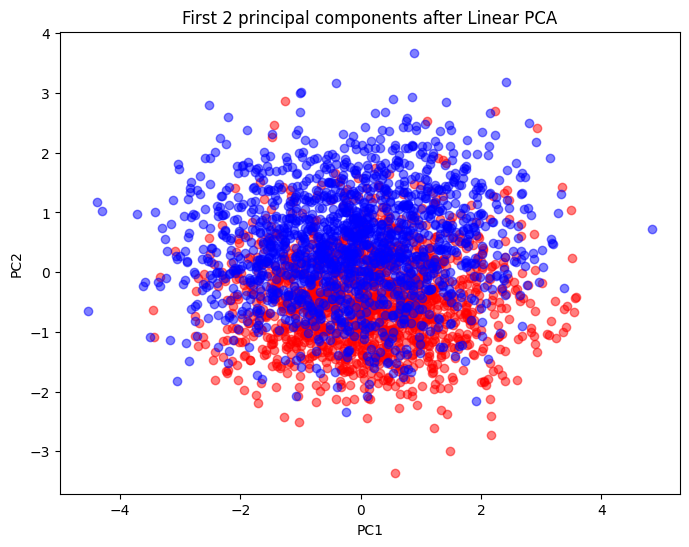

In [521]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X_scaled)

plot(X_spca, y, x_label='PC1', y_label='PC2', title='First 2 principal components after Linear PCA')

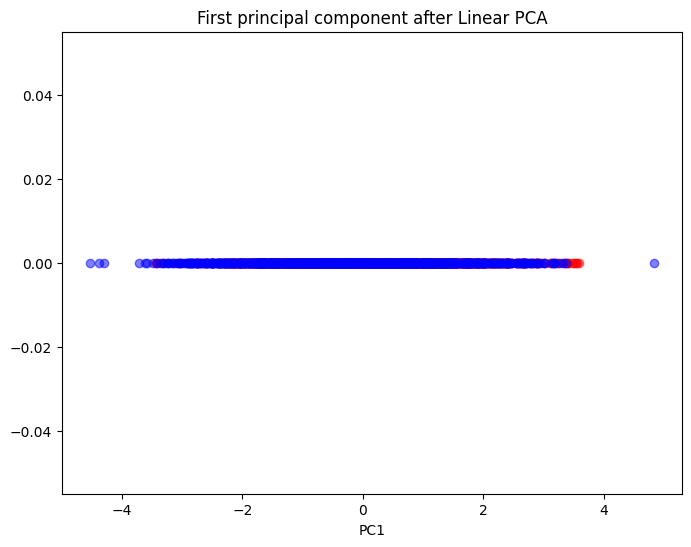

In [522]:
plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], np.zeros(X_spca[y==0, 0].shape), color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], np.zeros(X_spca[y==1, 0].shape), color='blue', alpha=0.5)

plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')

plt.show()

In [523]:
X_train_spca, X_test_spca, y_train_spca, y_test_spca = train_test_split(X_spca, y, stratify = y, random_state=0)

W_spca, L_spca = svm_training(X_train_spca, y_train_spca, lam=0, Iter=300, gamma=0.0001)

y_pred_spca = predlabels(X_test_spca, W_spca[:,-1])
acc(y_test_spca,y_pred_spca)

0.7093333333333334

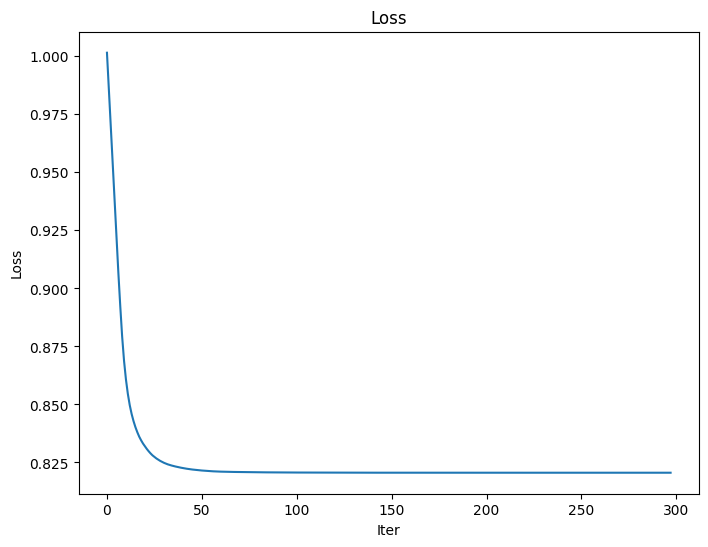

In [524]:
# plot loss

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(L_spca[0:-2])
ax.set_title('Loss')
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')

plt.show()

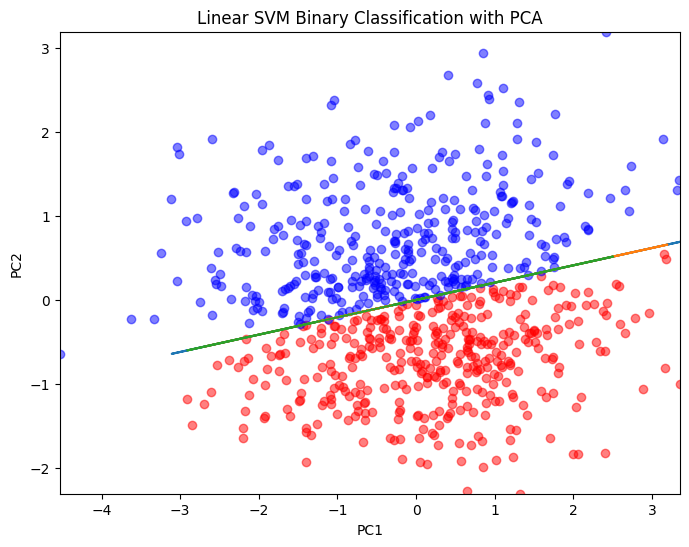

In [525]:
plot(X_test_spca, y_pred_spca, x_label='PC1', y_label='PC2', title='Linear SVM Binary Classification with PCA', hyperplane=[W_spca,L_spca])

0.7106666666666667


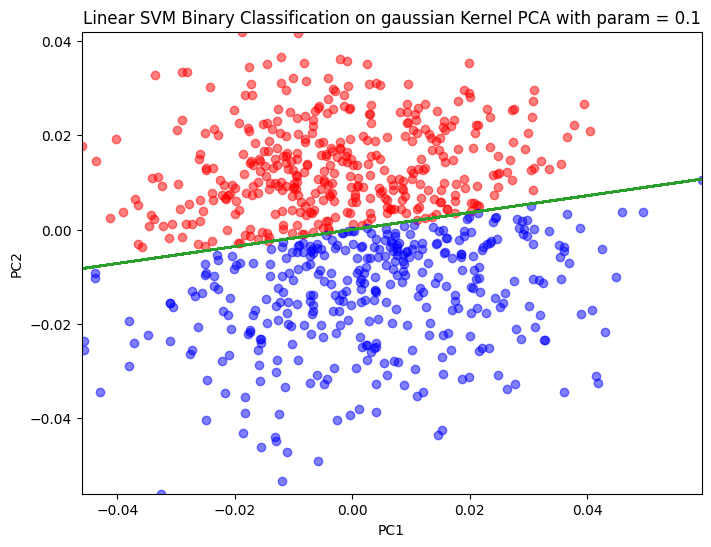

0.804


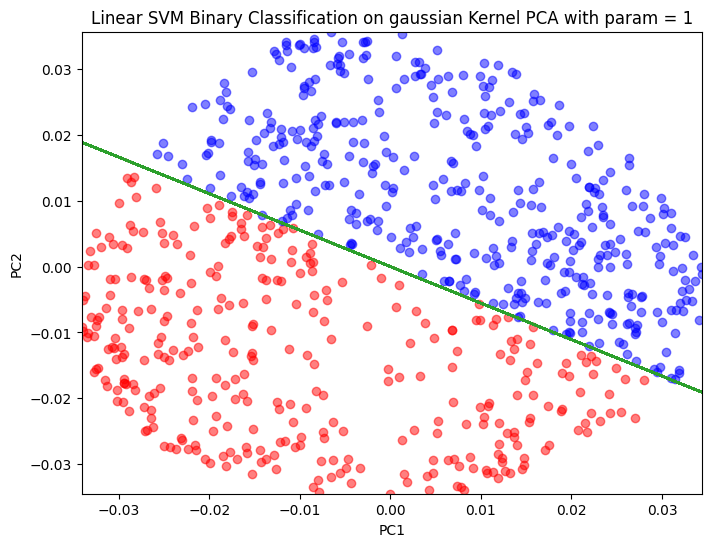

0.836


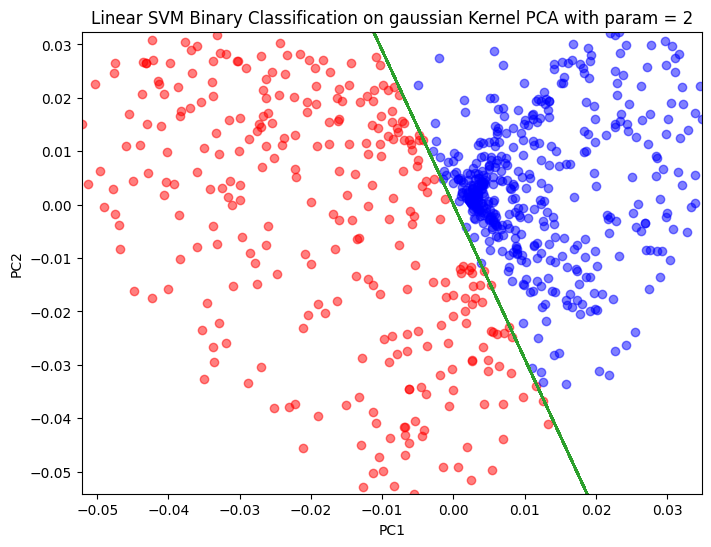

0.7853333333333333


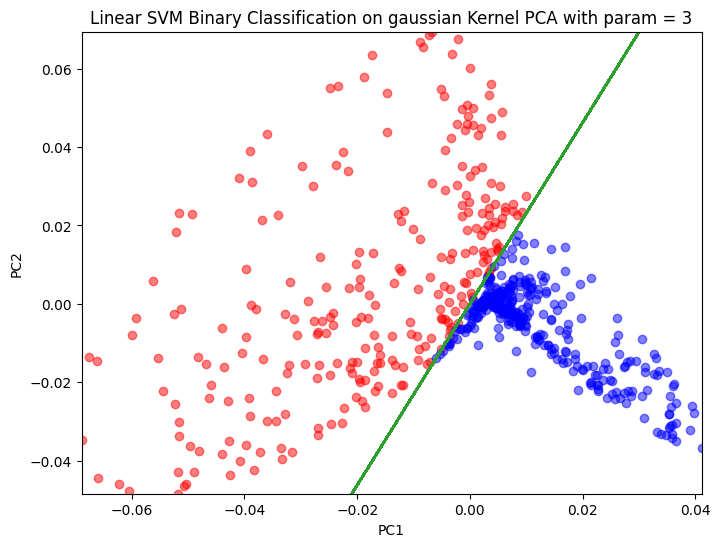

0.7653333333333333


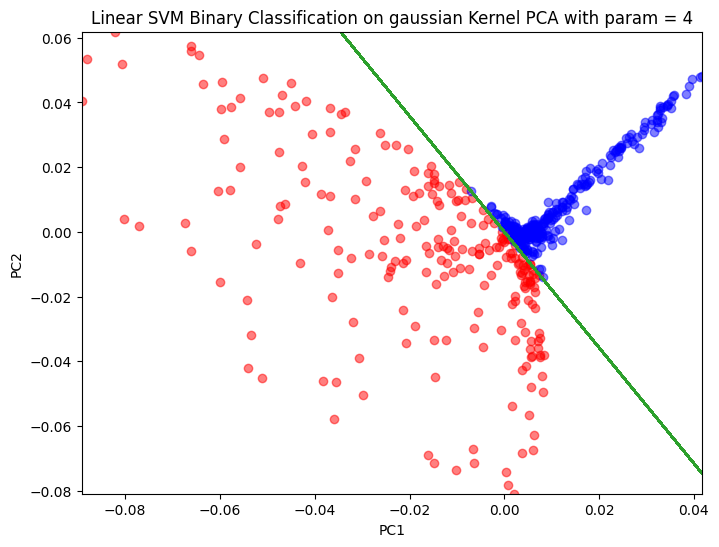

0.7253333333333334


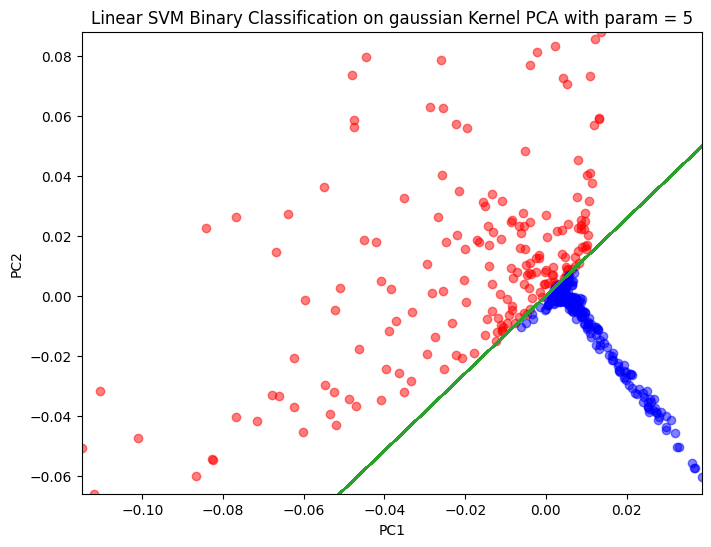

0.5786666666666667


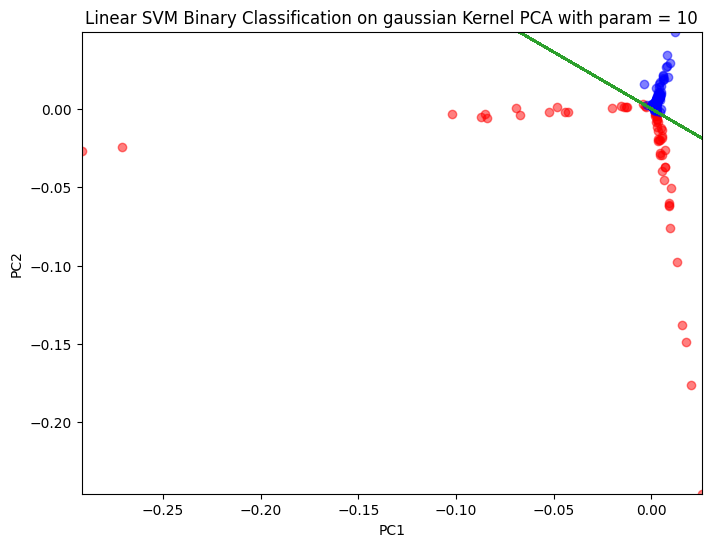

In [526]:
kernel_type = 'gaussian'
C = [0.1, 1, 2, 3, 4, 5, 10]

for j in C:

    X_kpca =  kpca(X_scaled, kernel_type, j, 2)
    X_train_kpca, X_test_kpca, y_train_kpca, y_test_kpca = train_test_split(X_kpca, y, stratify = y, random_state=0)

    W_kpca, L_kpca = svm_training(X_train_kpca, y_train_kpca, lam=0, Iter=500, gamma=0.0001)

    y_pred_kpca = predlabels(X_test_kpca, W_kpca[:,-1])
    print(acc(y_test_kpca,y_pred_kpca))

    plot(X_test_kpca, y_pred_kpca, x_label='PC1', y_label='PC2', title=f'Linear SVM Binary Classification on gaussian Kernel PCA with param = {j}', hyperplane=[W_kpca,L_kpca])

0.7093333333333334


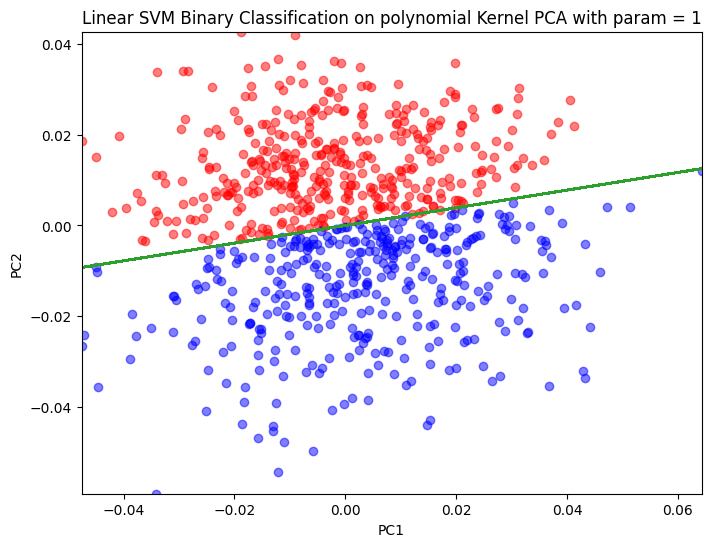

0.5506666666666666


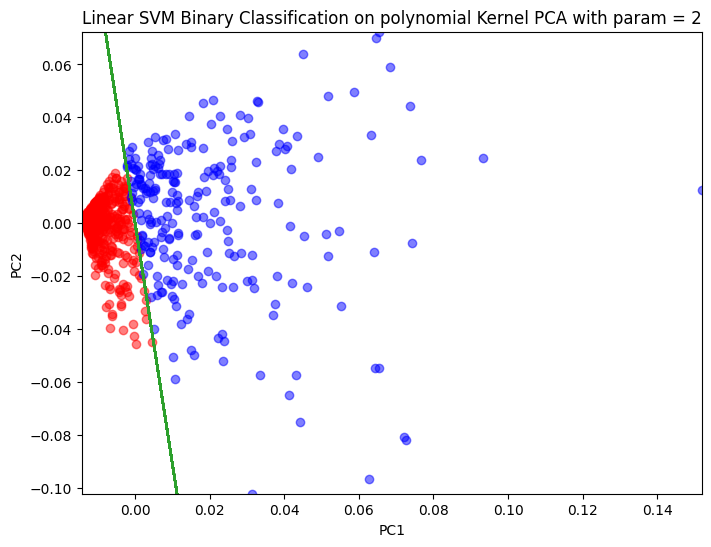

0.6666666666666666


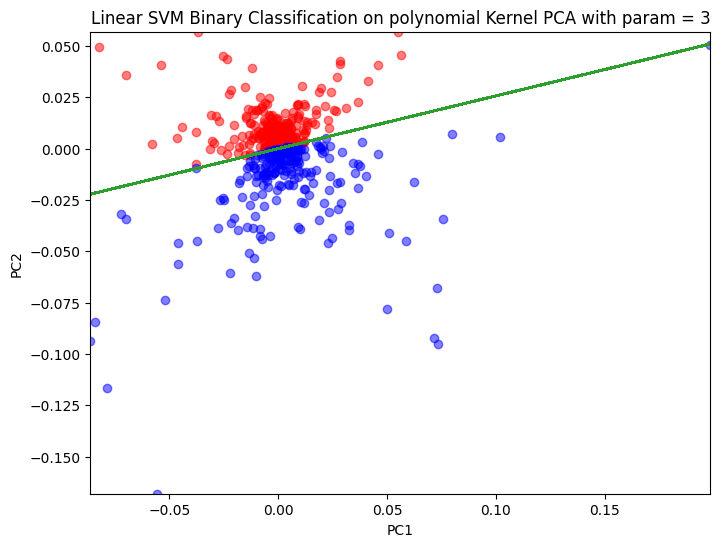

0.552


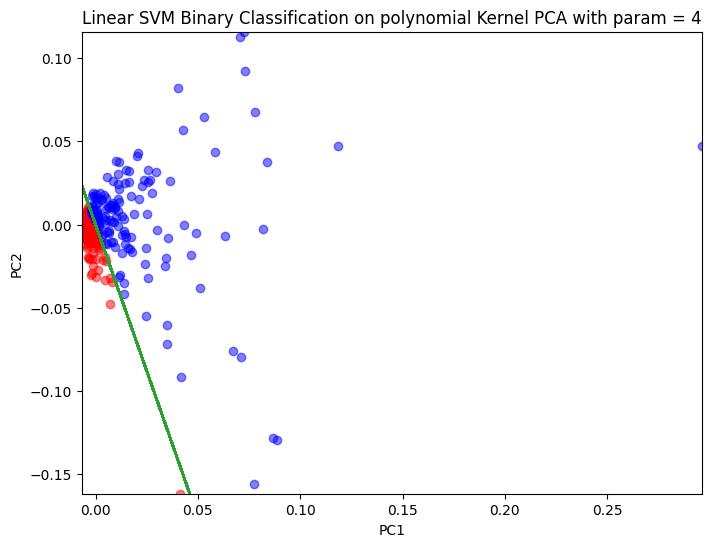

In [527]:
kernel_type = 'polynomial'
C = [1, 2, 3, 4]

for j in C:

    X_kpca =  kpca(X_scaled, kernel_type, j, 2)
    X_train_kpca, X_test_kpca, y_train_kpca, y_test_kpca = train_test_split(X_kpca, y, stratify = y, random_state=0)

    W_kpca, L_kpca = svm_training(X_train_kpca, y_train_kpca, lam=0, Iter=500, gamma=0.0001)

    y_pred_kpca = predlabels(X_test_kpca, W_kpca[:,-1])
    print(acc(y_test_kpca,y_pred_kpca))

    plot(X_test_kpca, y_pred_kpca, x_label='PC1', y_label='PC2', title=f'Linear SVM Binary Classification on polynomial Kernel PCA with param = {j}', hyperplane=[W_kpca,L_kpca])